In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import ruptures as rpt
from sklearn.model_selection import train_test_split
from kneed import KneeLocator
from scipy.stats import linregress
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import acf

from ruptures import Binseg, Pelt, Window
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

#TCN-autoencoder javítása

In [2]:
ecg_dataset = pd.read_csv('ecg.csv', header=None)
microsoft_stocks_dataset = pd.read_csv('Microsoft_Stock.csv')
month_value_dataset = pd.read_csv('Month_Value_1.csv')
yahoo_stocks_dataset = pd.read_csv('yahoo_stock.csv')

ecg_columns = [f'ECG_{i+1}' for i in range(140)]
ecg_dataset.columns = ecg_columns + ['label']

yahoo_stocks_dataset['Date'] = pd.to_datetime(yahoo_stocks_dataset['Date'])

In [3]:
month_value_dataset.columns

Index(['Period', 'Revenue', 'Sales_quantity', 'Average_cost',
       'The_average_annual_payroll_of_the_region'],
      dtype='object')

<Axes: >

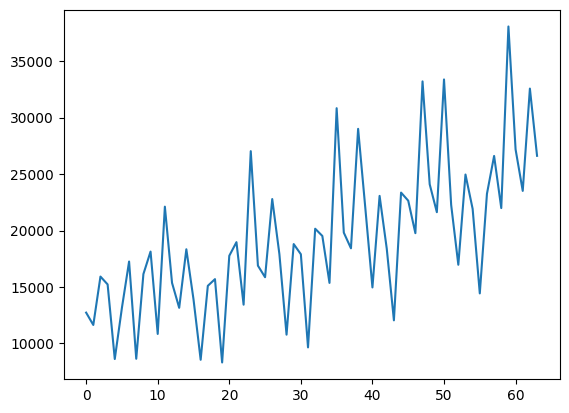

In [4]:
month_value_dataset['Sales_quantity'].plot()

In [5]:
microsoft_stocks_dataset.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

<Axes: >

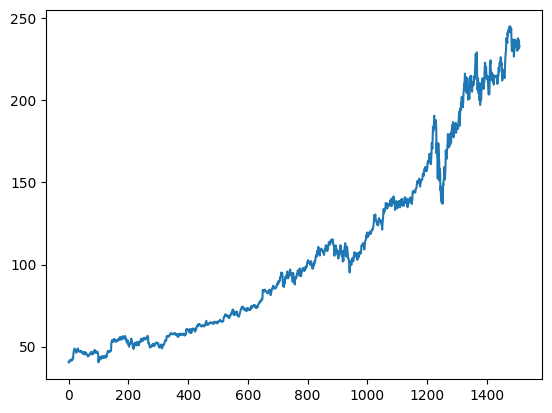

In [6]:
microsoft_stocks_dataset['Open'].plot()

<Axes: >

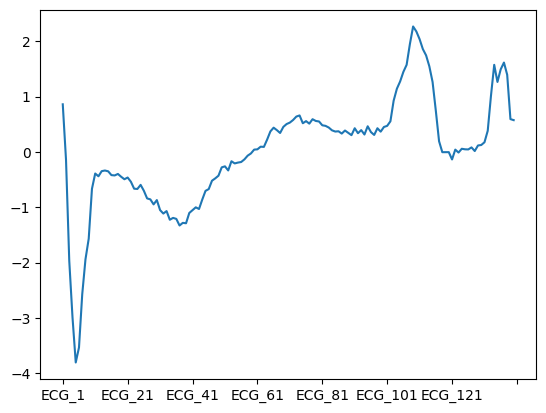

In [7]:
ecg_dataset.loc[40, ecg_columns].plot()

In [8]:
yahoo_stocks_dataset.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

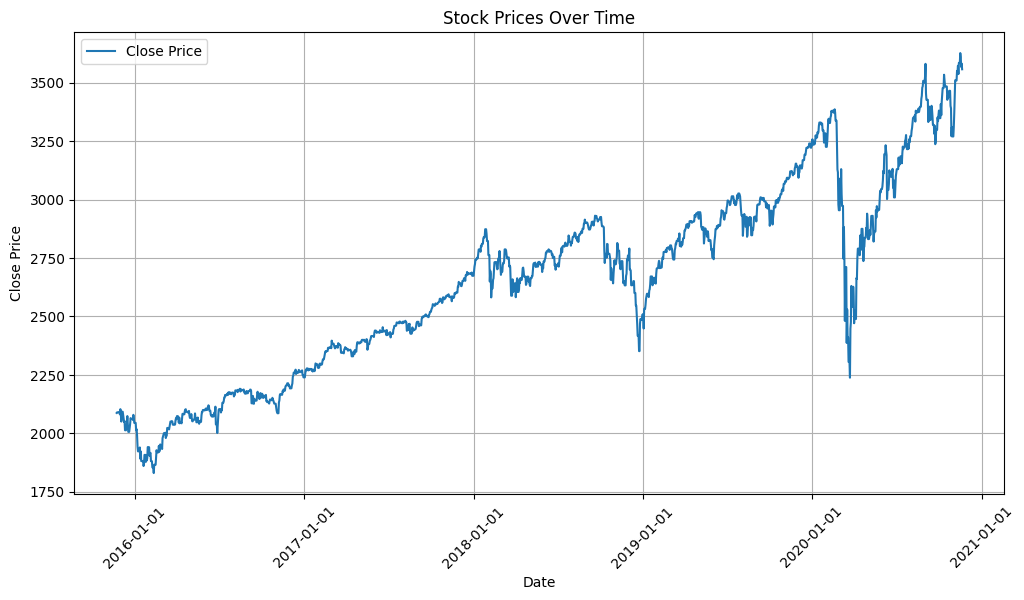

In [9]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(yahoo_stocks_dataset['Date'], yahoo_stocks_dataset['Close'], label="Close Price")

# Format the x-axis to show some dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically chooses a good interval
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as YYYY-MM-DD

# Rotate dates for better visibility
plt.xticks(rotation=45)

# Labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [10]:
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.data_loader import load_tssb_dataset, load_has_dataset
from time_series_segmentation_benchmark.tssb.utils import load_time_series_segmentation_datasets
from time_series_segmentation_benchmark.tssb.evaluation import covering, f_measure

In [11]:
from tqdm import tqdm

def calculate_score(dataset, algorithm):
    score_sum = 0
    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        ts_name = row['dataset']
        window_size = row['window_size']
        cps = row['change_points']
        ts = row['time_series']
        
        found_cps = algorithm(ts)
        score = covering({0: cps}, found_cps, ts.shape[0])
        score_sum += score
    return score_sum / len(dataset)

def calculate_weighted_f1(dataset, algorithm):
    weighted_score_sum = 0
    total_weight = 0
    
    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        ts_name = row['dataset']
        window_size = row['window_size']
        cps = row['change_points']
        ts = row['time_series']
        
        found_cps = algorithm(ts)
        score = f_measure({0: cps}, found_cps, ts.shape[0])
        
        weight = len(ts)
        weighted_score_sum += score * weight
        total_weight += weight

    return weighted_score_sum / total_weight if total_weight > 0 else 0

def calculate_f1(dataset, algorithm):
    f1_sum = 0
    for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
        ts_name = row['dataset']
        window_size = row['window_size']
        cps = row['change_points']
        ts = row['time_series']
        
        found_cps = algorithm(ts)
        score = f_measure({0: cps}, found_cps, ts.shape[0])
        f1_sum += score
    return f1_sum / len(dataset) if len(dataset) > 0 else 0

In [12]:
dataset, window_size, true_cps, time_series = load_tssb_dataset(names=("CricketX",)).iloc[0,:]
clasp = BinaryClaSPSegmentation()
clasp.fit_predict(time_series)


array([ 712, 1281, 1933, 2581])

array([<Axes: title={'center': 'Segmentation of different umpire cricket signals'}, ylabel='ACC'>,
       <Axes: xlabel='split point', ylabel='ClaSP Score'>], dtype=object)

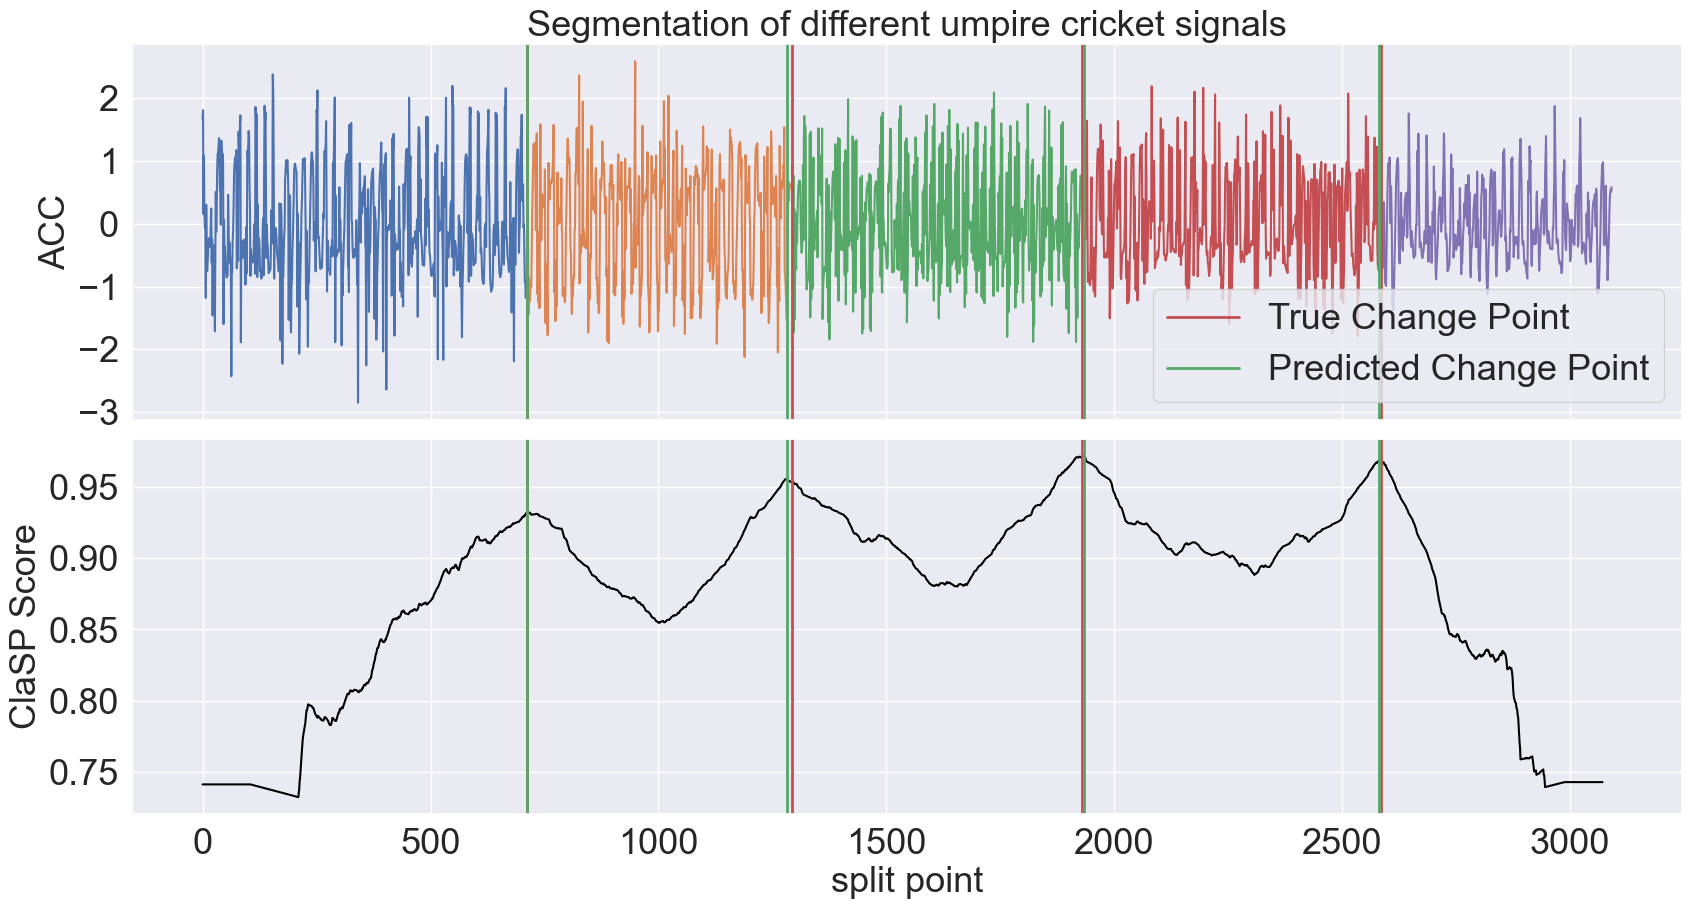

In [13]:
clasp.plot(gt_cps=true_cps, heading="Segmentation of different umpire cricket signals", ts_name="ACC", file_path="segmentation_example.png")

In [14]:
tssb = load_time_series_segmentation_datasets()

has = load_has_dataset()
has.columns = ['dataset', 'window_size', 'change_points', 'labels','time_series']

In [15]:
def CLaSP_segmenter(ts):
    clasp = BinaryClaSPSegmentation()
    clasp.fit_predict(ts)
    return clasp.change_points

In [15]:
calculate_score(has.iloc[:10], CLaSP_segmenter)

100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


0.6856879959036984

In [16]:
def plot_changepoints_on_ts(ts, cps, title, real_cps):
    plt.figure(figsize=(12, 6))
    plt.plot(ts, label='Time Series', color='blue', linewidth=2)
    
    for cp in cps:
         plt.axvline(cp, color='red', linestyle='--', linewidth=3.5, label='Detected Changepoint')
    for cp in real_cps:
         plt.axvline(cp, color='red', linestyle='-.', linewidth=3.5, label='Real Changepoint')
        
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    
    #plt.title(f"{title} ", fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

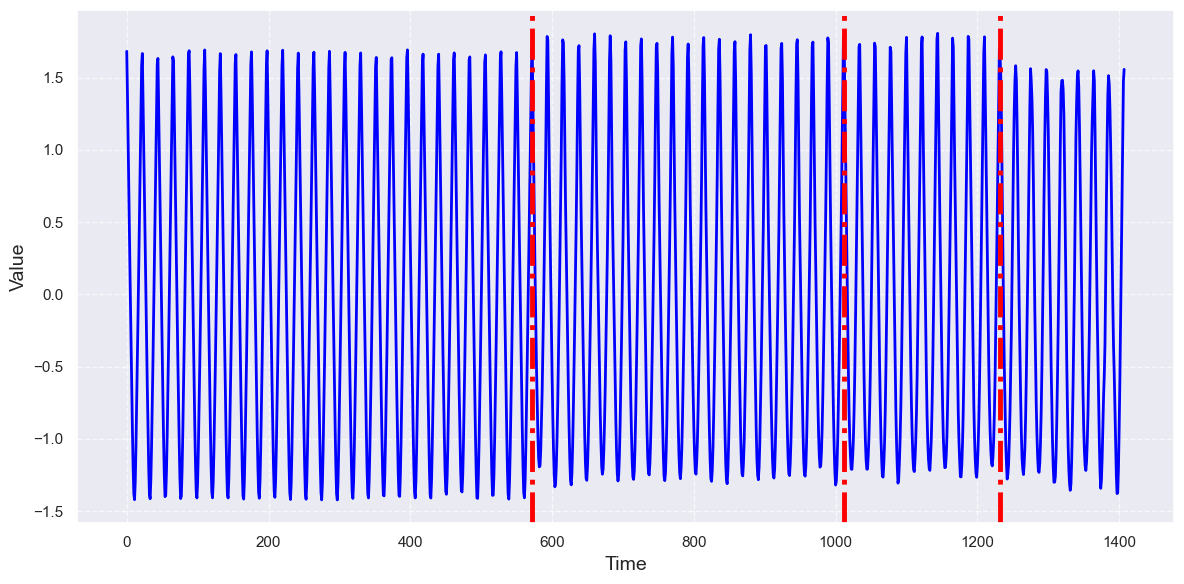

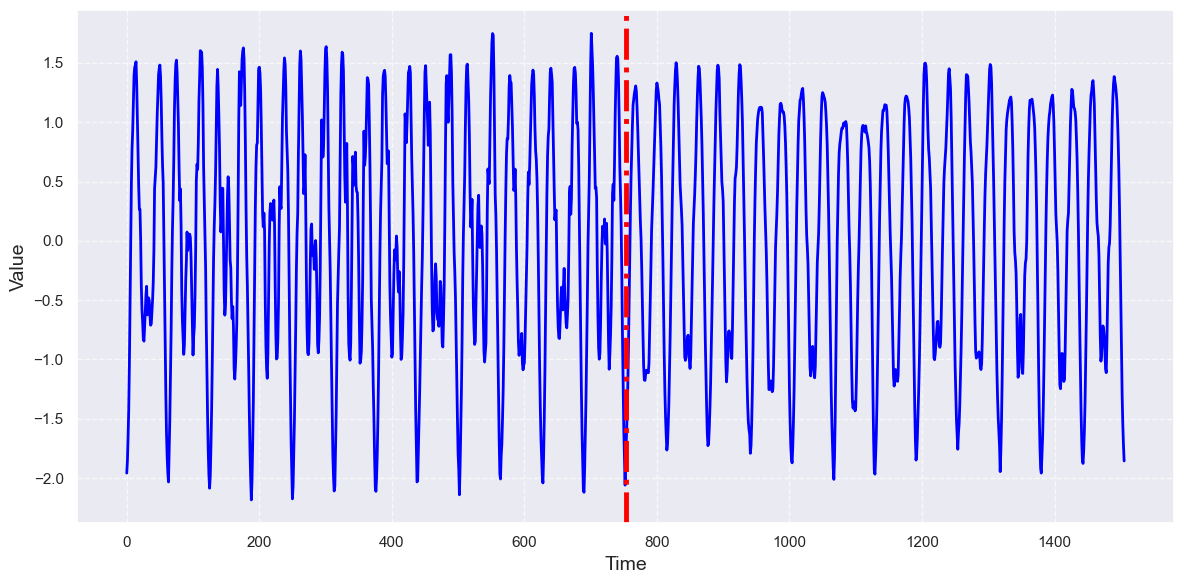

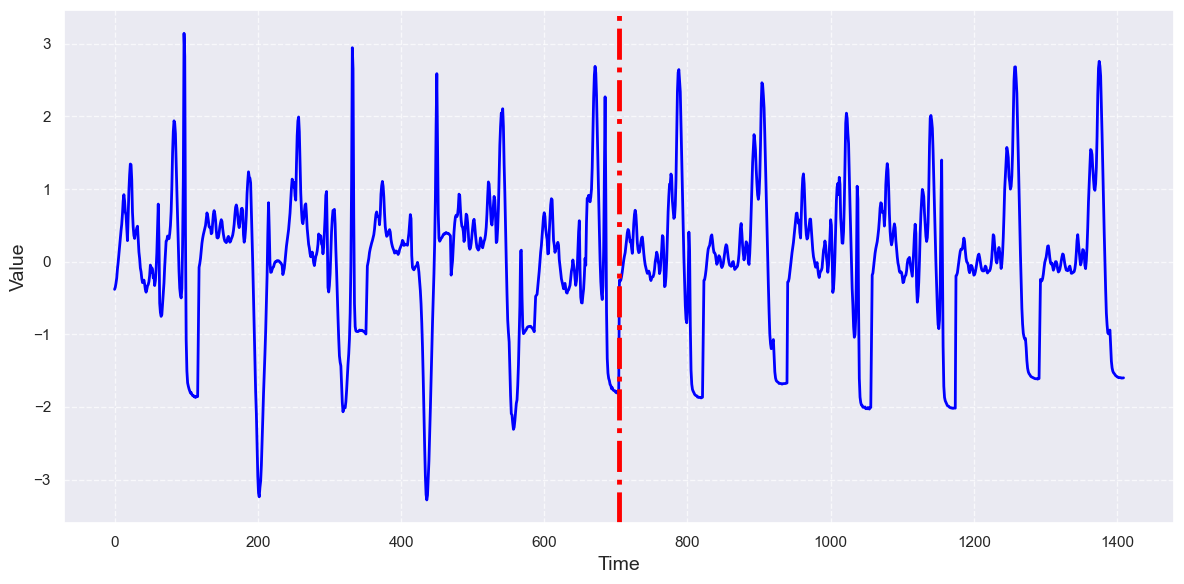

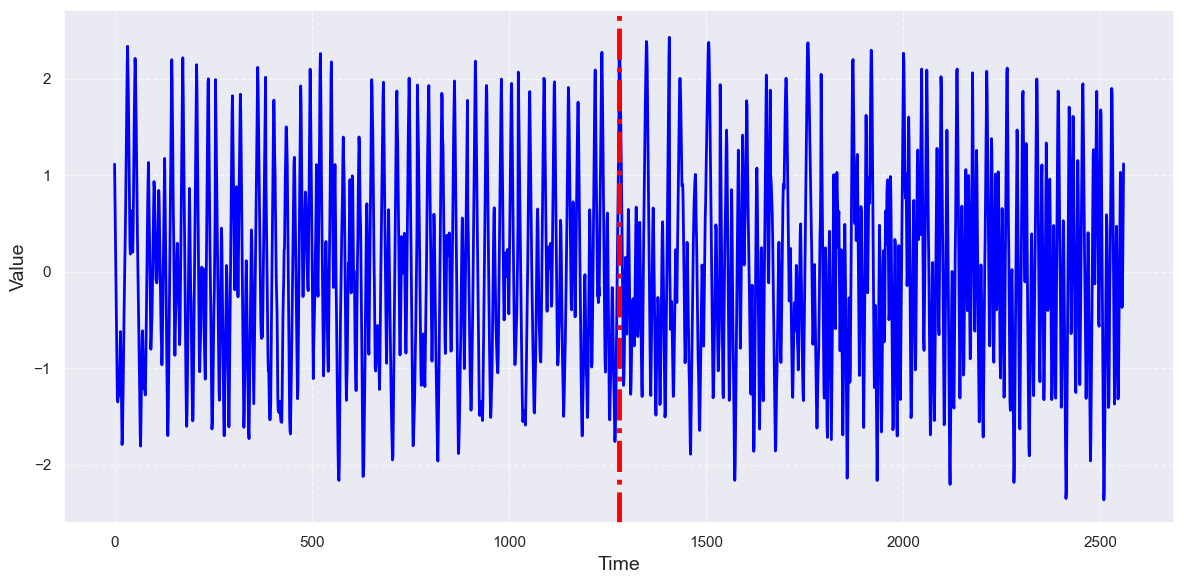

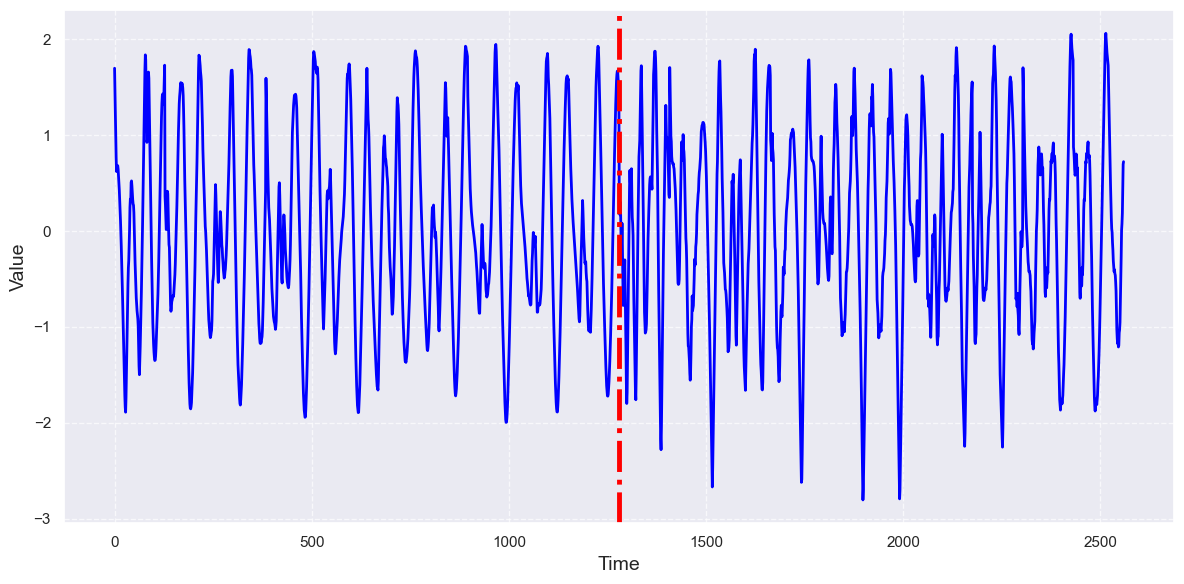

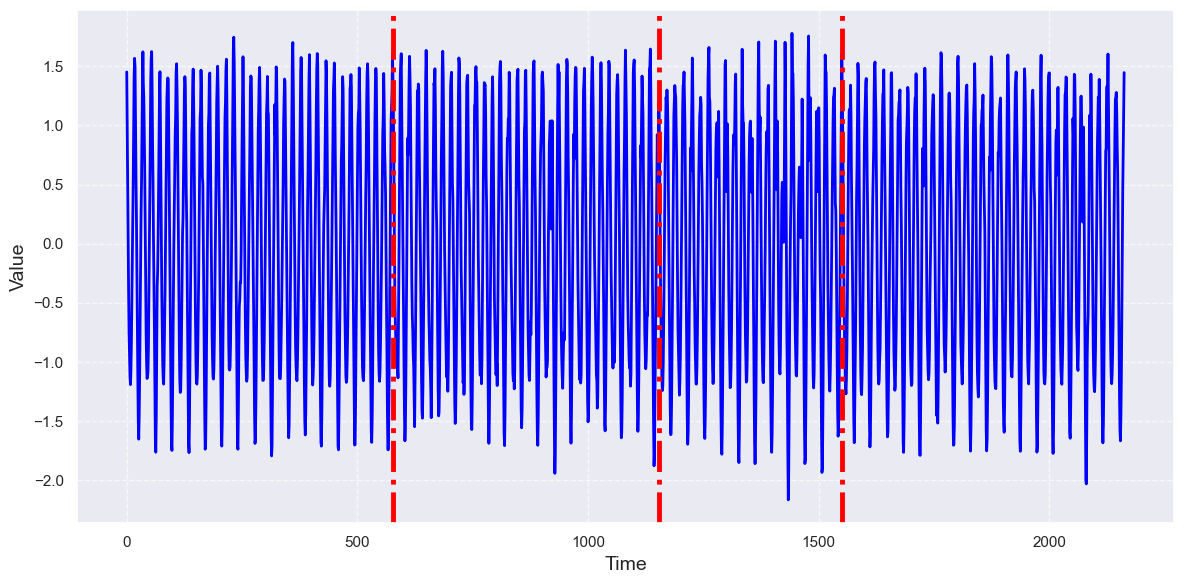

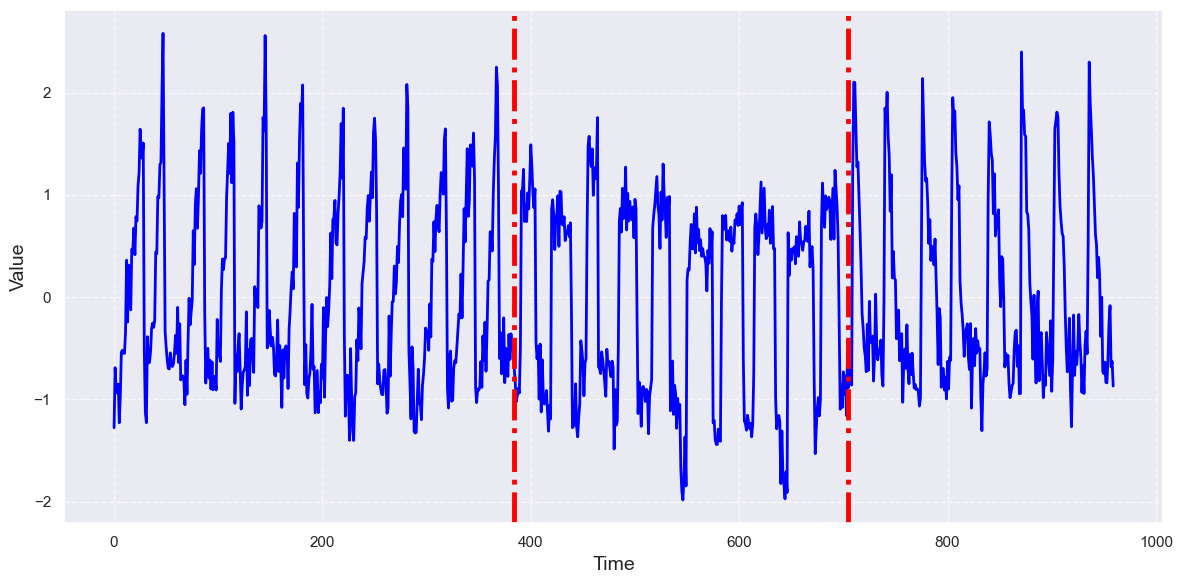

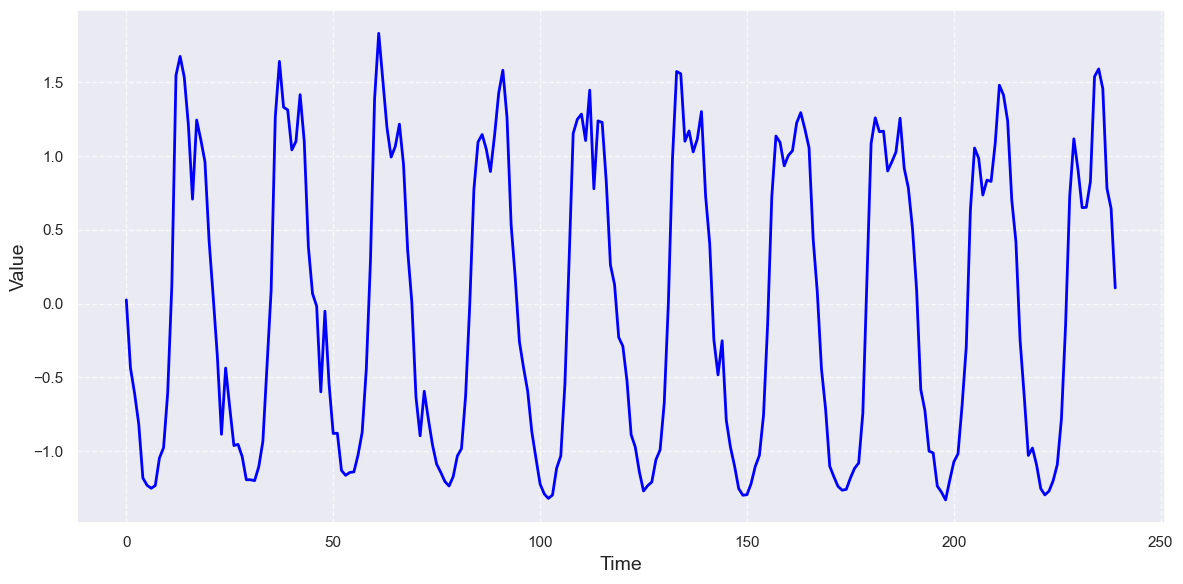

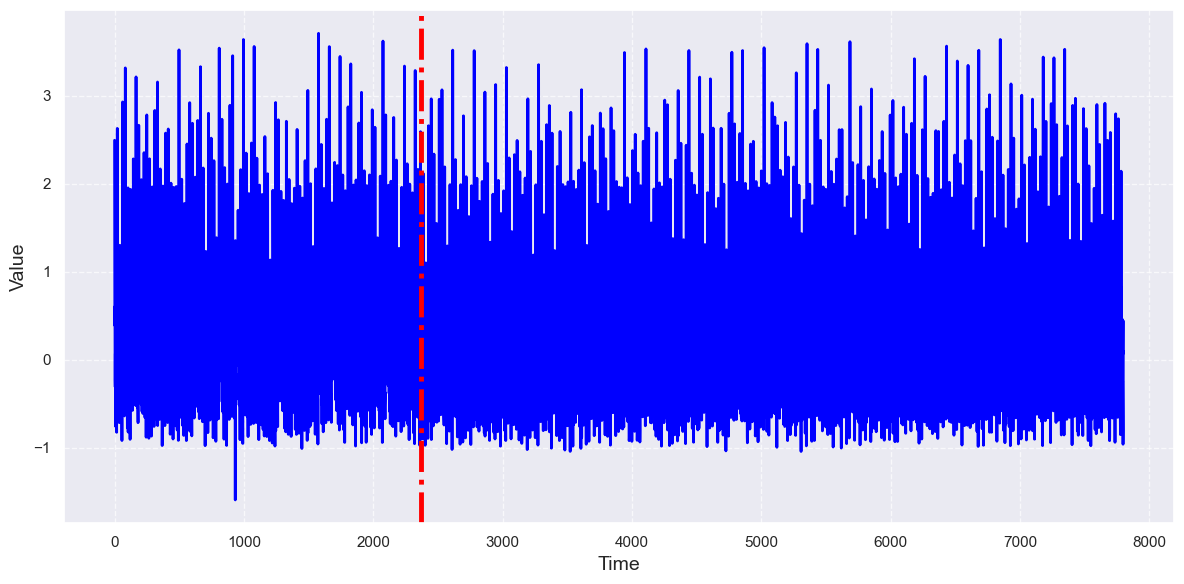

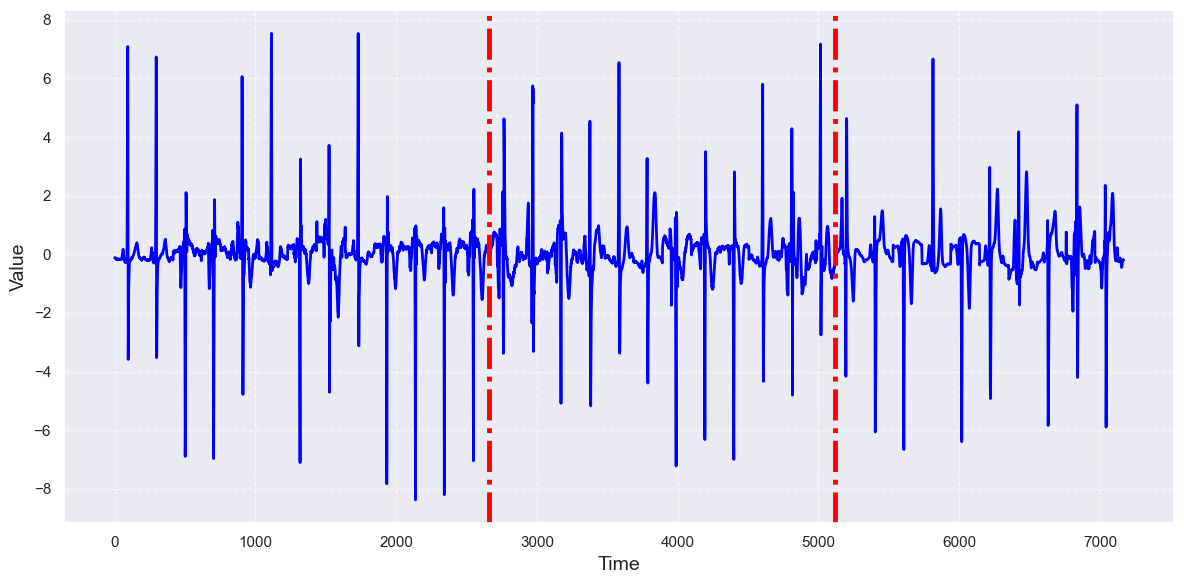

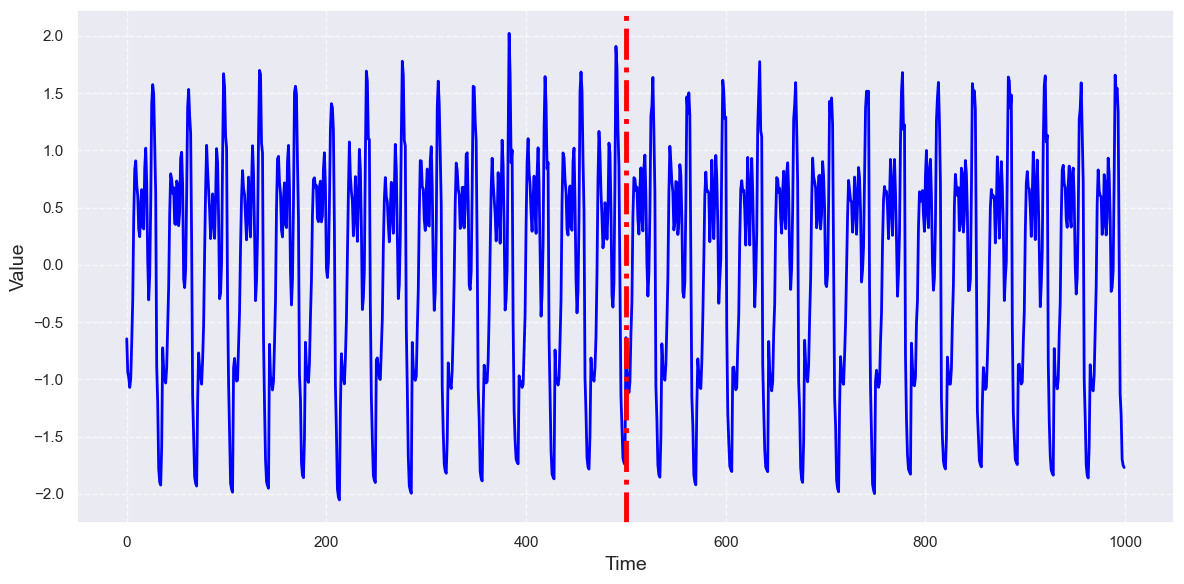

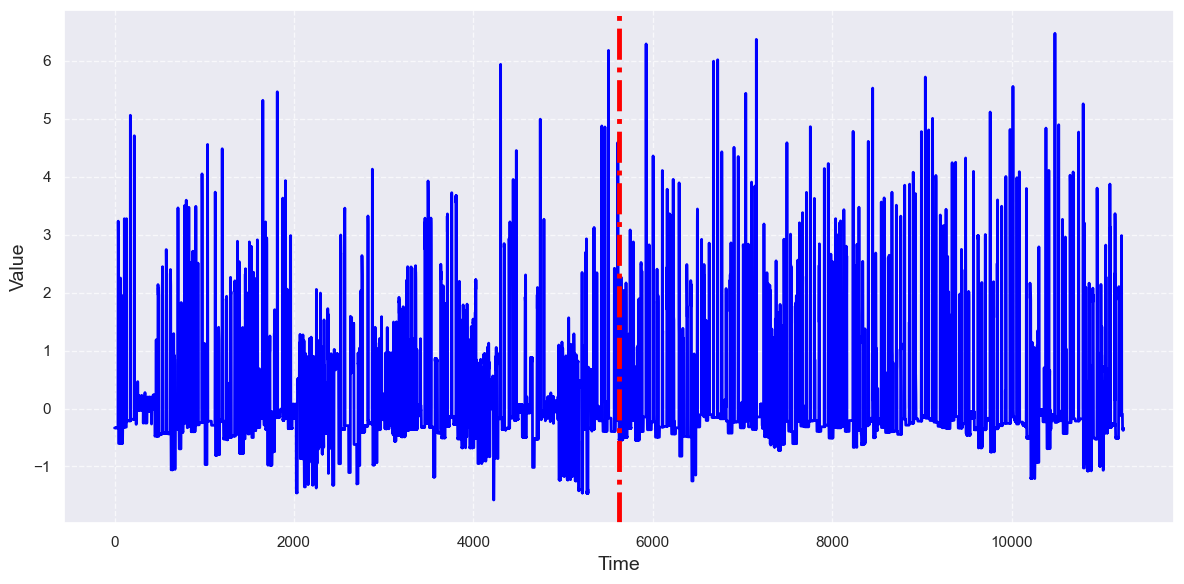

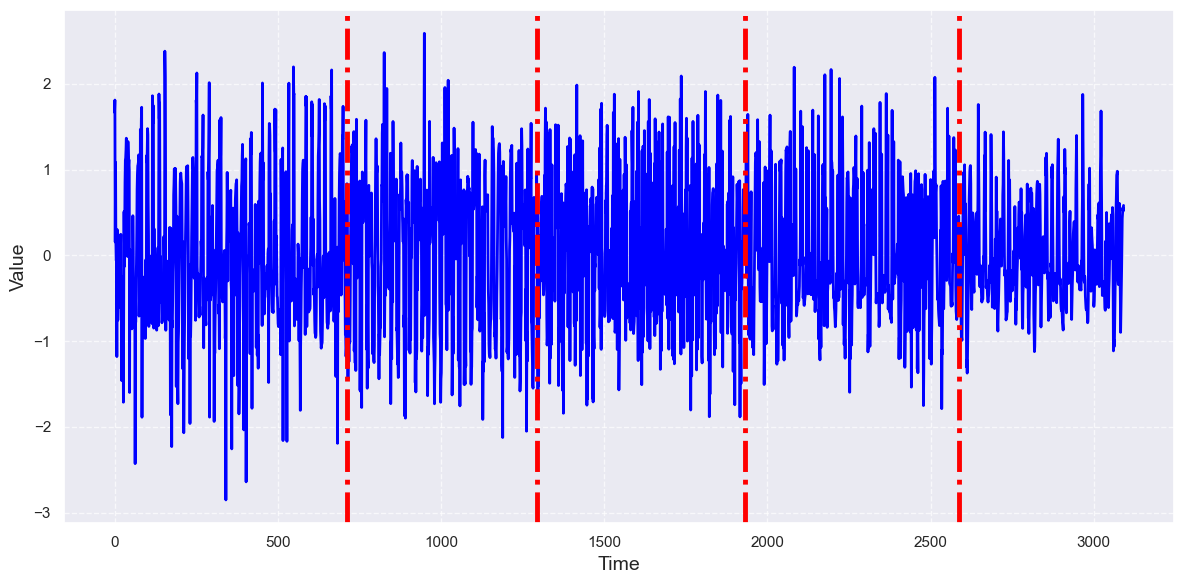

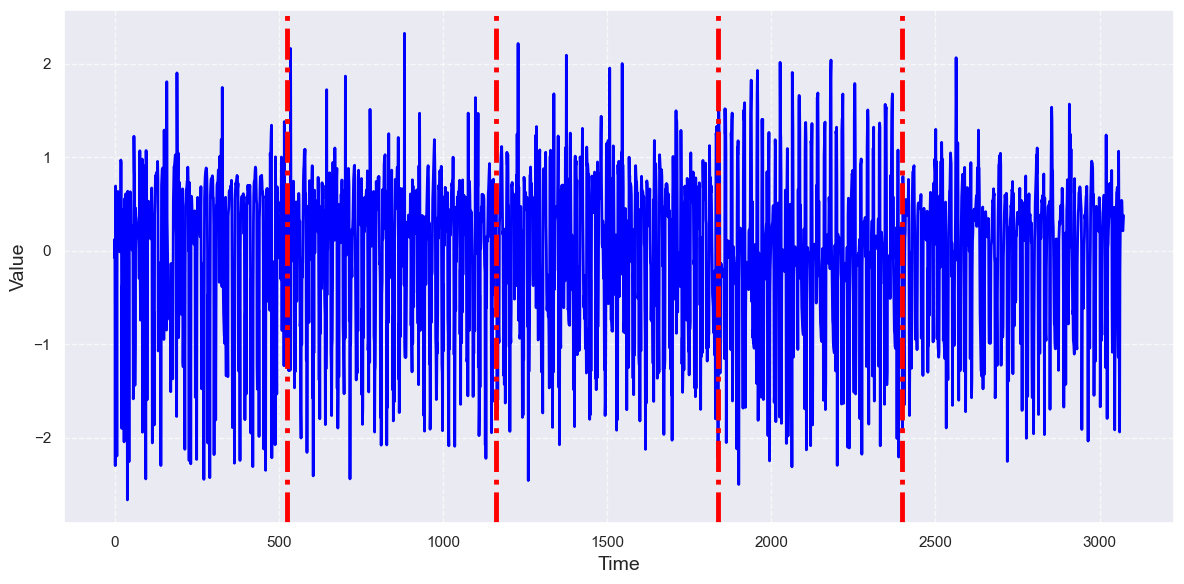

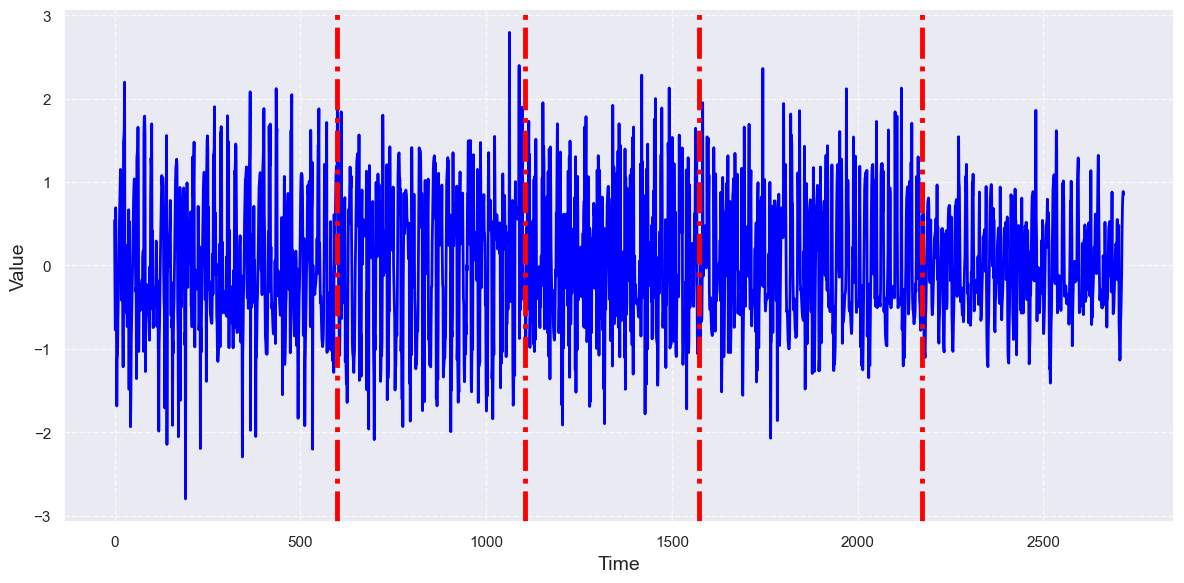

In [80]:

for i in range(15):
    change_points = CLaSP_segmenter(tssb.loc[i, 'time_series'])

    plot_changepoints_on_ts(tssb.loc[i, 'time_series'], change_points, tssb.loc[i, 'dataset'], tssb.loc[i, 'change_points'])

In [18]:
tssb.head(1)

dataset  window_size      change_points  \
0   Adiac           10  [572, 1012, 1232]   

                                         time_series  
0  [1.681146, 1.383394, 1.029389, 0.688386, 0.354...

# Change point detection

In [15]:
ecg_data = ecg_dataset[ecg_columns].values

In [16]:
# Select first ECG signal (Row 0)
which_row = 30
#ecg_signal = ecg_data[which_row]
ecg_signal = np.array(microsoft_stocks_dataset['Open'])  # Change index to analyze another row

# Apply change point detection (Pelt Algorithm with L2 cost)
algo = rpt.Pelt(model="l2").fit(ecg_signal.reshape(-1, 1))
change_points = algo.predict(pen=3000)  # Adjust 'pen' for more/less segmentation

# Print detected change points
print("Change Points Detected:", change_points)


Change Points Detected: [145, 395, 520, 650, 795, 995, 1055, 1165, 1215, 1235, 1265, 1315, 1465, 1511]


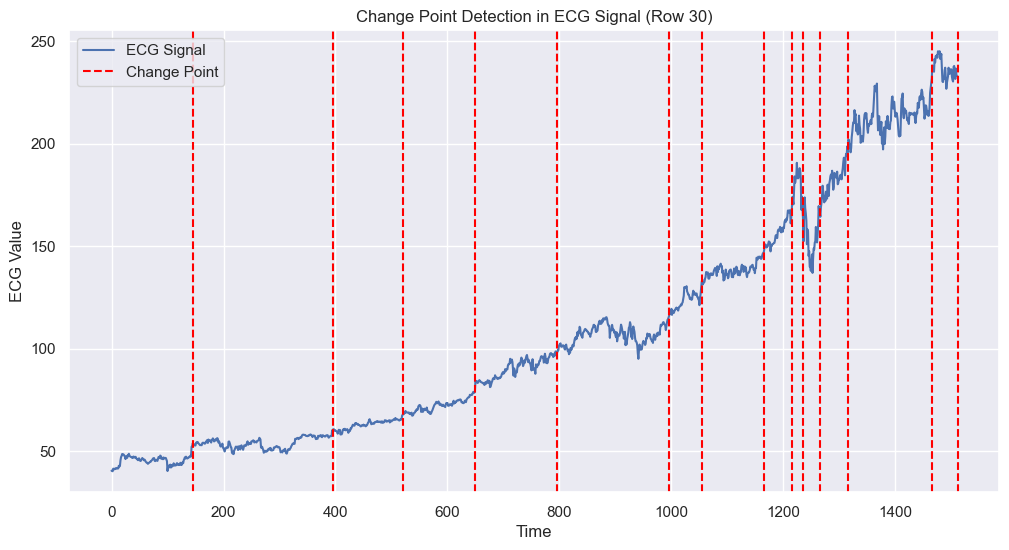

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label="ECG Signal")

# Mark detected change points
for cp in change_points:
    plt.axvline(x=cp, color='red', linestyle='--', label="Change Point" if cp == change_points[0] else "")

plt.legend()
plt.title("Change Point Detection in ECG Signal (Row " + str(which_row) + ")")
plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.show()


# KMeans

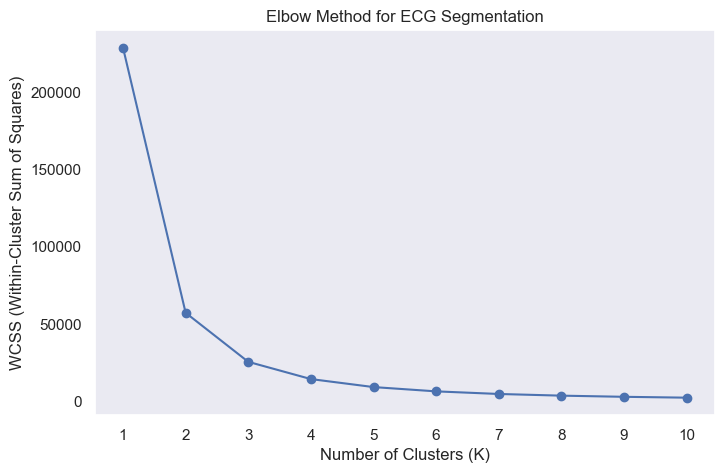

In [18]:
from sklearn.cluster import KMeans

which_row = 0

# Select one ECG signal (first row, ignoring label)
ecg_signal = ecg_dataset.iloc[which_row, :-1].values  # Assuming last column is "label"

# Create features: (time index, ECG value)
time_steps = np.arange(len(ecg_signal)).reshape(-1, 1)
X = np.column_stack((time_steps, ecg_signal))  # Combine time & ECG values

# Apply Elbow Method to find the best K
wcss = []
K_values = range(1, 11)  # Test K from 1 to 10

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_values, wcss, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for ECG Segmentation")
plt.xticks(K_values)
plt.grid()
plt.show()

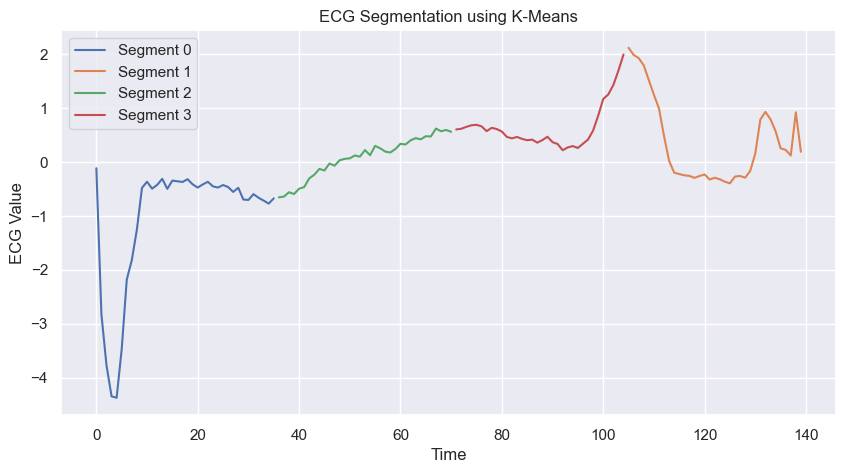

In [19]:
# Apply K-Means with the best K (replace with your best K value)
best_K = 4  # Example value, replace with the best K found from elbow method
kmeans = KMeans(n_clusters=best_K, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Plot the segmented ECG signal
plt.figure(figsize=(10, 5))
for cluster in np.unique(labels):
    plt.plot(time_steps[labels == cluster], ecg_signal[labels == cluster], label=f'Segment {cluster}')

plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.title("ECG Segmentation using K-Means")
plt.legend()
plt.show()


# Time series KMeans

In [17]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


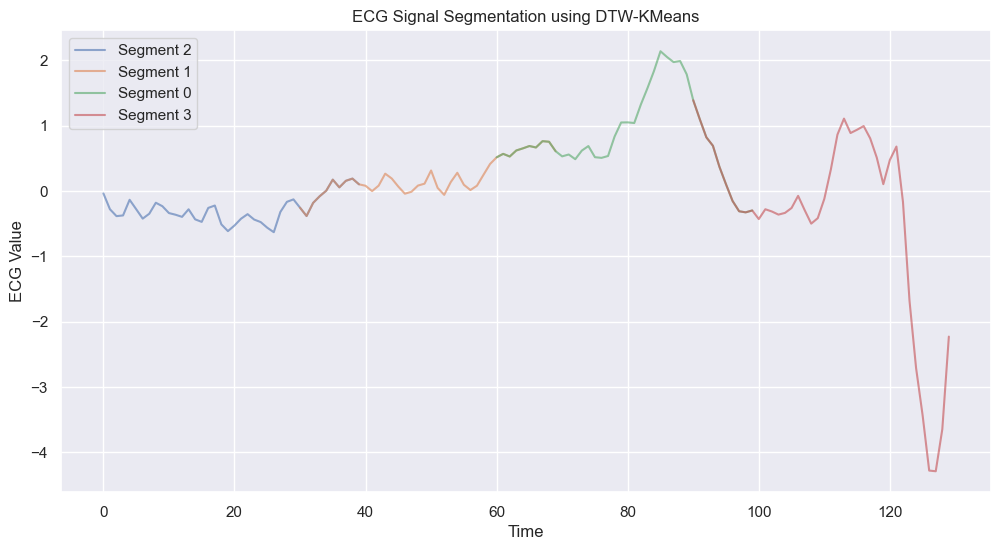

In [18]:
# Select a single ECG signal (e.g., first row)
ecg_signal = ecg_dataset.iloc[30, :-1].values  # Assuming last column is "label"

# Define segmentation parameters
window_size = 40  # Number of points per segment
stride = 30  # Step size for segment extraction

# Create overlapping segments
segments = [ecg_signal[i:i+window_size] for i in range(0, len(ecg_signal)-window_size, stride)]
segments = np.array(segments)

# Normalize segments
segments_scaled = TimeSeriesScalerMeanVariance().fit_transform(segments)

# Apply DTW-KMeans
n_clusters = 4  # Adjust based on elbow method
dtw_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
labels = dtw_kmeans.fit_predict(segments_scaled)

# Plot segmented ECG signal
plt.figure(figsize=(12, 6))
time_axis = np.arange(len(ecg_signal))

for i, segment_start in enumerate(range(0, len(ecg_signal)-window_size, stride)):
    plt.plot(time_axis[segment_start:segment_start+window_size], ecg_signal[segment_start:segment_start+window_size], 
             label=f"Segment {labels[i]}", alpha=0.6)

plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.title("ECG Signal Segmentation using DTW-KMeans")
plt.legend()
plt.show()

# BinarySegmentation

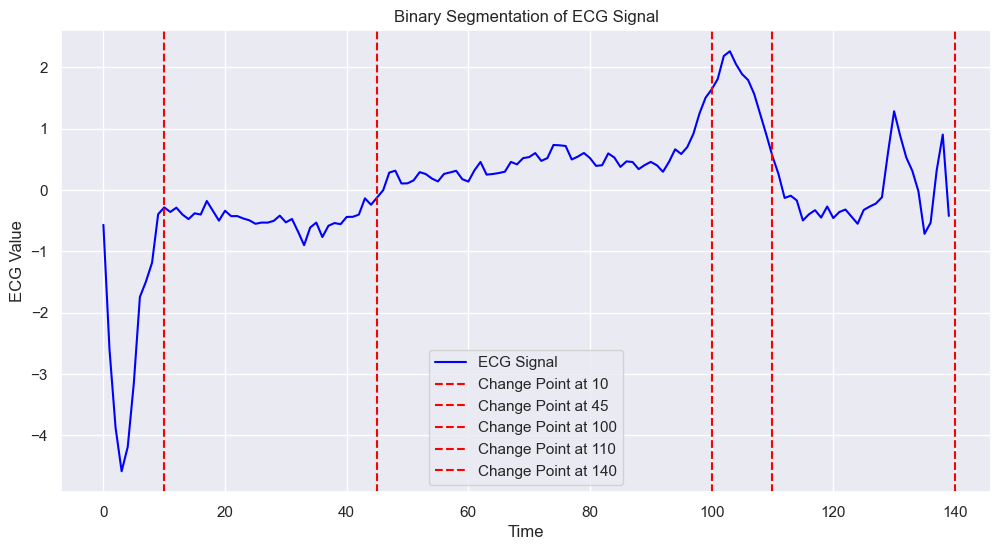

In [19]:
which_row = 2

# Select a single ECG signal (e.g., first row)
ecg_signal = ecg_dataset.iloc[which_row, :-1].values  # Assuming last column is "label"

# Define parameters for the binary segmentation
model = "l2"  # Model used for change point detection (l2: least squares)
algo = rpt.Binseg(model=model).fit(ecg_signal)  # Binary segmentation algorithm

# Detect change points
break_points = 4  # Number of change points to detect
change_points = algo.predict(n_bkps=break_points)  # Set n_bkps=1 for one change point

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label="ECG Signal", color="blue")
for cp in change_points:
    plt.axvline(x=cp, color="red", linestyle="--", label=f"Change Point at {cp}")
plt.title("Binary Segmentation of ECG Signal")
plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.legend()
plt.show()

# TCN-based autoencoder

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm

In [21]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1, dropout=0.2):
        super(TCNBlock, self).__init__()
        padding = (kernel_size - 1) * dilation // 2
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout)
        self.residual = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None

    def forward(self, x):
        res = x if self.residual is None else self.residual(x)
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x + res

In [22]:
class TCN_Autoencoder(nn.Module):
    def __init__(self):
        super(TCN_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            TCNBlock(1, 32, kernel_size=3, dilation=1),
            TCNBlock(32, 64, kernel_size=3, dilation=2),
            TCNBlock(64, 16, kernel_size=3, dilation=4),
        )
        self.decoder = nn.Sequential(
            TCNBlock(16, 64, kernel_size=3, dilation=4),
            TCNBlock(64, 32, kernel_size=3, dilation=2),
            nn.Conv1d(32, 1, kernel_size=3, padding=1)  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [23]:
def rolling_window_error(reconstruction_error, window_size, threshold_factor):
    rolling_mean = np.convolve(reconstruction_error, np.ones(window_size) / window_size, mode='same')
    rolling_std = np.sqrt(np.convolve((reconstruction_error - rolling_mean) ** 2, 
                                      np.ones(window_size) / window_size, mode='same'))

    change_points = np.where(reconstruction_error > (rolling_mean + threshold_factor * rolling_std))[0]
    
    return change_points



def TCNAutoencoder_segmenter(signal, epochs=380, window_size=50, threshold_factor=4.0):
    torch.manual_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    signal = torch.tensor(signal, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,T]
    model = TCN_Autoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20)

    for _ in range(epochs):
        optimizer.zero_grad()
        output = model(signal)
        loss = criterion(output, signal)
        loss.backward()
        optimizer.step()
        scheduler.step(loss)
    
    reconstruction_error = torch.abs(output.squeeze() - signal.squeeze()).cpu().detach().numpy()
    change_points = rolling_window_error(reconstruction_error, window_size, threshold_factor)

    reconstructed_signal = output.squeeze().cpu().detach().numpy()
    original_signal = signal.squeeze().cpu().detach().numpy()

    #Plot results
    # plt.figure(figsize=(10, 4))
    # plt.plot(original_signal, label="Original Signal")
    # plt.plot(reconstruction_error, label="Reconstruction Error", color='orange')
    # plt.plot(reconstructed_signal, label="Reconstructed Signal", linestyle='dashed')
    # plt.scatter(change_points, original_signal[change_points], color='red', label="Change Points")
    # plt.legend()
    # plt.title("Signal Segmentation using TCN Autoencoder with Rolling Window")
    # plt.show()

    return change_points

In [21]:
# Example usage (assuming 'ecg_df' is your dataset)
#signal = ecg_dataset.iloc[3, :-1].values
signal = np.array(microsoft_stocks_dataset['Open'])

change_points = TCNAutoencoder_segmenter(signal)
print("Detected change points:", change_points)

Detected change points: [   0  455  649 1510]


In [24]:
has_for_tcnautoencoder = load_has_dataset()
has_for_tcnautoencoder.columns = ['dataset', 'window_size', 'change_points', 'labels','time_series']

In [25]:
has_for_tcnautoencoder['time_series'] = has_for_tcnautoencoder['time_series'].apply(lambda x: np.array([item[0] for item in x]))
has_for_tcnautoencoder=has_for_tcnautoencoder.drop(columns=['labels'])

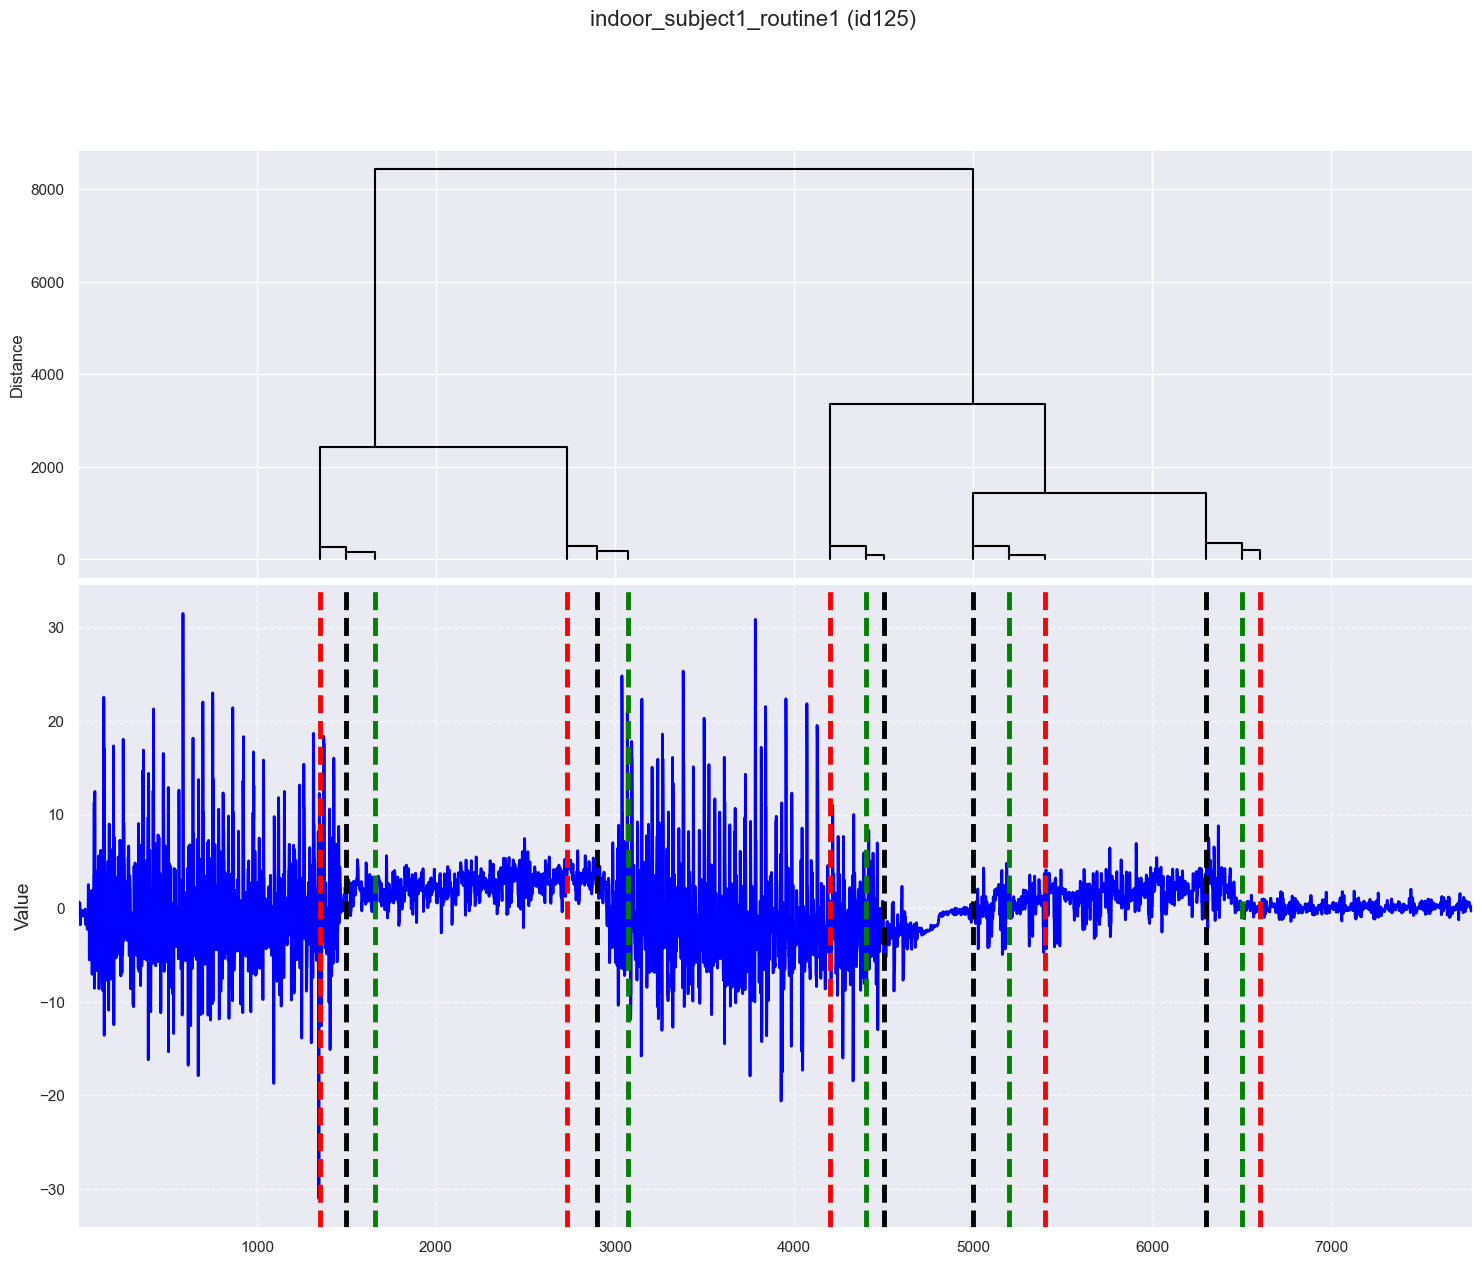

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

def plot_changepoints_on_ts2(ts, title):
    red_lines = [1350, 2730, 4200, 5400, 6600]
    black_lines = [1500, 2900, 4500, 5000, 6300]
    green_lines = [1660, 3070, 4400, 5200, 6500]

    changepoints = sorted(red_lines + black_lines + green_lines)
    changepoints_array = np.array(changepoints).reshape(-1, 1)
    linked = linkage(changepoints_array, method='ward')

    fig = plt.figure(figsize=(18, 14))
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1.5], hspace=0.01)

    ax_dendro = fig.add_subplot(gs[0])
    ax_ts = fig.add_subplot(gs[1], sharex=ax_dendro)

    # Run dendrogram without plotting to access coordinates
    dendro = dendrogram(linked, labels=changepoints, no_plot=True)

    # Get leaf order and true positions
    leaf_order = dendro['leaves']
    leaf_positions = [changepoints[i] for i in leaf_order]
    position_map = {i: pos for i, pos in zip(leaf_order, leaf_positions)}

    # Plot dendrogram manually with mapped x-positions
    for xs, ys in zip(dendro['icoord'], dendro['dcoord']):
        x_mapped = [position_map.get(int((x - 5) / 10), changepoints[0]) for x in xs]
        ax_dendro.plot(x_mapped, ys, color='black')

    ax_dendro.set_ylabel("Distance")
    ax_dendro.set_xlim(0, len(ts))
    ax_dendro.set_xticks([])


    # Plot time series
    ax_ts.plot(ts, label='Time Series', color='blue', linewidth=2)

    for line in red_lines:
        ax_ts.axvline(line, color='red', linestyle='--', linewidth=3.5)
    for line in black_lines:
        ax_ts.axvline(line, color='black', linestyle='--', linewidth=3.5)
    for line in green_lines:
        ax_ts.axvline(line, color='green', linestyle='--', linewidth=3.5)


    ax_ts.set_ylabel("Value", fontsize=14)
    ax_ts.grid(True, linestyle='--', alpha=0.7)
    ax_ts.set_xlim(0, len(ts))
    ax_ts.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])

    plt.suptitle(title, fontsize=16)
    plt.show()







for i in range(1):
    plot_changepoints_on_ts2(
        has_for_tcnautoencoder.loc[i, 'time_series'],
        has_for_tcnautoencoder.loc[i, 'dataset']
    )


In [27]:
has_for_tcnautoencoder.loc[i, 'change_points']

array([1461, 2952, 4473, 5022, 6460])

In [81]:
calculate_weighted_f1(has_for_tcnautoencoder.iloc[0:30], TCNAutoencoder_segmenter)

100%|██████████| 30/30 [03:11<00:00,  6.37s/it]


0.46321179727498163

In [111]:
calculate_score(has_for_tcnautoencoder.iloc[10:35], TCNAutoencoder_segmenter)

100%|██████████| 25/25 [00:43<00:00,  1.73s/it]


0.5278729380939473

# CLaSP on ecg_dataset

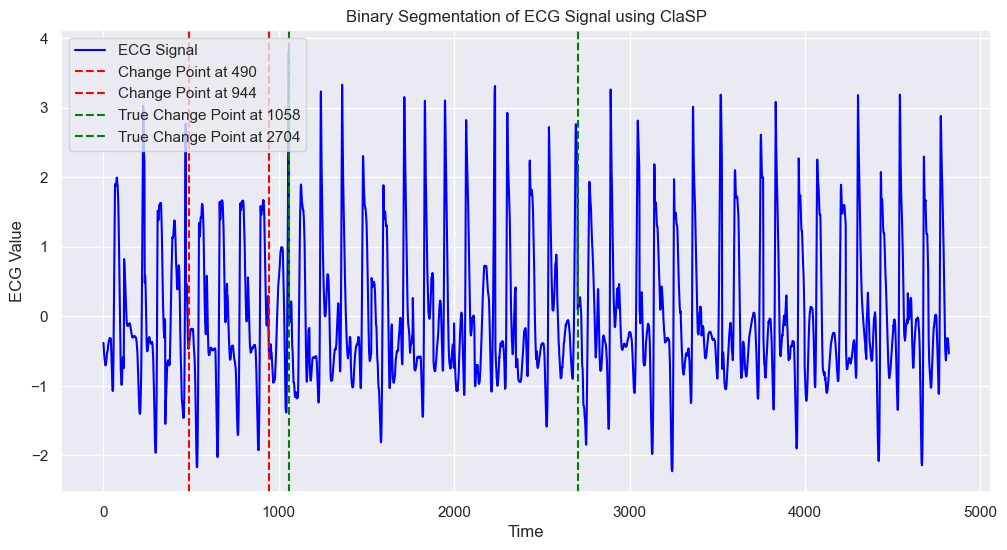

Detected change points: [490 944]


In [28]:
which_row = 34

# Select a single ECG signal (e.g., first row)
#signal = np.array(microsoft_stocks_dataset['Open'])
signal = tssb.loc[which_row, 'time_series']
found_cps = BinaryClaSPSegmentation().fit_predict(signal)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(signal, label="ECG Signal", color="blue")
for cp in found_cps:
    plt.axvline(x=cp, color="red", linestyle="--", label=f"Change Point at {cp}")
for cp in tssb.loc[which_row, 'change_points']:
    plt.axvline(x=cp, color="green", linestyle="--", label=f"True Change Point at {cp}")
plt.title("Binary Segmentation of ECG Signal using ClaSP")
plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.legend()
plt.show()

print("Detected change points:", found_cps)



In [29]:
from scipy.cluster.hierarchy import inconsistent

def find_optimal_threshold(Z, max_depth=10):
    max_variation = 0
    best_threshold = None

    for depth in range(1, max_depth + 1):
        inconsistency = inconsistent(Z, depth)
        threshold = np.mean(inconsistency[:, 3]) + np.std(inconsistency[:, 3])
        variation = np.std(inconsistency[:, 3])

        if variation > max_variation:
            max_variation = variation
            best_threshold = threshold
    
    return best_threshold

# Modellek

In [30]:
def optimize_pelt(ts, model="l2", penalty_range=np.linspace(1, 20, 5)):
    costs = []
    n_segments = []

    for penalty in penalty_range:
        algo = rpt.Pelt(model=model, min_size=len(ts)/6).fit(ts)
        bkps = algo.predict(pen=penalty)
        
        cost = np.sum(np.diff([0] + bkps) ** 2)
        costs.append(cost)
        n_segments.append(len(bkps))

    knee = KneeLocator(penalty_range, costs, curve="convex", direction="decreasing")
    optimal_penalty = knee.knee

    return optimal_penalty if optimal_penalty != None else penalty_range.mean()

def pelt_segmenter(ts, model="l2"):
    optimal_penalty = optimize_pelt(ts, model=model)
    algo = Pelt(model=model, min_size=len(ts)/6).fit(ts)
    return algo.predict(pen=optimal_penalty)

def binseg_segmenter(ts, model="l2"):
    algo = rpt.Binseg(model=model).fit(ts)
    
    max_bkps = min(15, len(ts) // 25)  
    costs = []
    n_bkps_range = np.arange(1, max_bkps + 1)
    
    for n_bkps in n_bkps_range:
        bkps = algo.predict(n_bkps=n_bkps)
        cost = algo.cost.sum_of_costs(bkps)
        costs.append(cost)
    
    kneedle = KneeLocator(n_bkps_range, costs, curve="convex", direction="decreasing")
    optimal_bkps = kneedle.elbow if kneedle.elbow else max_bkps // 2 
    
    return algo.predict(n_bkps=optimal_bkps)

def bottomup_segmenter(ts, model="l2"):
    algo = rpt.BottomUp(model=model).fit(ts)
    
    max_bkps = min(15, len(ts) // 25)
  
    costs = []
    n_bkps_range = np.arange(1, max_bkps + 1)
    
    for n_bkps in n_bkps_range:
        bkps = algo.predict(n_bkps=n_bkps)
        cost = algo.cost.sum_of_costs(bkps)
        costs.append(cost)
    
   
    kneedle = KneeLocator(n_bkps_range, costs, curve="convex", direction="decreasing")
    optimal_bkps = kneedle.elbow if kneedle.elbow else max_bkps // 2  
    
    return algo.predict(n_bkps=optimal_bkps)

def window_segmenter(ts, model="l2", width=None):
    ts = np.array(ts)  

   
    if width is None:
        width = max(5, len(ts) // 20)  

    algo = Window(model=model, width=width).fit(ts)

    
    max_bkps = min(15, len(ts) // (2 * width))  
    variances = []
    bkps_range = list(range(1, max_bkps + 1))

    for n_bkps in bkps_range:
        change_points = algo.predict(n_bkps=n_bkps)
        segment_lengths = np.diff([0] + change_points + [len(ts)])  
        variances.append(np.var(segment_lengths))  

    kneedle = KneeLocator(bkps_range, variances, curve="convex", direction="decreasing")
    optimal_bkps = kneedle.elbow if kneedle.elbow else 1

    return algo.predict(n_bkps=optimal_bkps)




# ENSEMBLE MODELS

Pelt, BinarySegmentation és BottomUp közös modellje. Végén egy hierarchikus klaszterezéssel megállapítva a change pointokat.

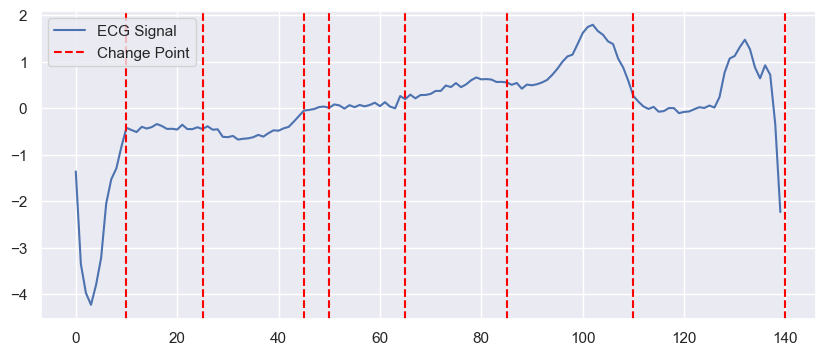

In [34]:
# Example signal
signal = ecg_dataset.iloc[20, :-1].values

# Change point detection using different algorithms
algo1 = pelt_segmenter(signal)
algo2 = binseg_segmenter(signal)
algo3 = bottomup_segmenter(signal)

# Combine all detected change points into a single list
all_bkps = np.concatenate([algo1, algo2, algo3])

# Perform hierarchical clustering on the combined list
Z = linkage(all_bkps.reshape(-1, 1), method='ward')

# Determine clusters based on a distance threshold
distance_threshold = find_optimal_threshold(Z)  # Adjust this value as needed
clusters = fcluster(Z, t=distance_threshold, criterion='distance')

# Select the representative change point from each cluster (e.g., the median)
ensemble_bkps = []
for cluster_id in np.unique(clusters):
    cluster_points = all_bkps[clusters == cluster_id]
    representative_point = np.mean(cluster_points)
    ensemble_bkps.append(representative_point)

# Sort the final change points
ensemble_bkps = np.sort(ensemble_bkps)

# Eredmény ábrázolása
plt.figure(figsize=(10,4))
plt.plot(signal, label="ECG Signal")
for cp in ensemble_bkps:
    plt.axvline(x=cp, color="red", linestyle="--", label="Change Point" if cp == ensemble_bkps[0] else "")
plt.legend()
plt.show()

In [32]:
def PeltBinSegBottomUP_segmenter(ts):
    # Change point detection using different algorithms
    algo1 = pelt_segmenter(ts)
    algo2 = binseg_segmenter(ts)
    algo3 = bottomup_segmenter(ts)

    # Combine all detected change points into a single list
    all_bkps = np.concatenate([algo1, algo2, algo3])

    # Perform hierarchical clustering on the combined list
    Z = linkage(all_bkps.reshape(-1, 1), method='ward')

    # Determine clusters based on a distance threshold
    distance_threshold = find_optimal_threshold(Z)  # Adjust this value as needed
    clusters = fcluster(Z, t=distance_threshold, criterion='distance')

    # Select the representative change point from each cluster (e.g., the median)
    ensemble_bkps = []
    for cluster_id in np.unique(clusters):
        cluster_points = all_bkps[clusters == cluster_id]
        representative_point = np.mean(cluster_points)
        ensemble_bkps.append(representative_point)

    # Sort the final change points
    ensemble_bkps = np.sort(ensemble_bkps)

    return ensemble_bkps

In [36]:
calculate_score(has.iloc[:10], PeltBinSegBottomUP_segmenter)

  0%|          | 0/10 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/kneed/knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))
100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


0.8335551511563881

CLaSP Window BinSeg együttes modellje

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(


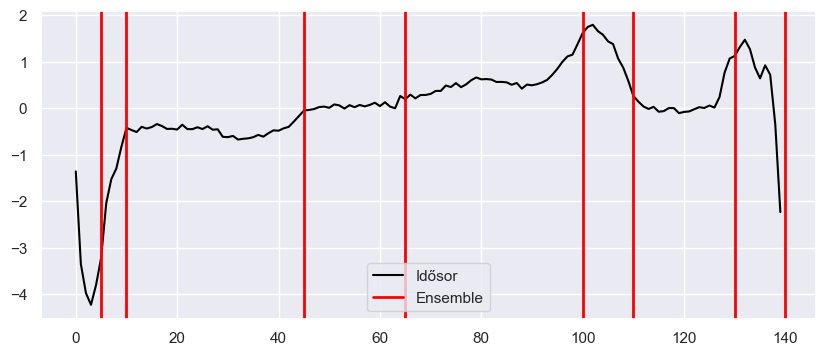

In [35]:
signal = ecg_dataset.iloc[20, :-1].values

# 🔹 ClaSP szegmentáció
breakpoints_clasp = CLaSP_segmenter(signal)

# 🔹 Binary Segmentation (ruptures)
breakpoints_binseg = binseg_segmenter(signal)

# 🔹 Window Segmentation (ruptures)
breakpoints_window = window_segmenter(signal)

all_bkps = np.concatenate([breakpoints_clasp, breakpoints_binseg, breakpoints_window])

# Perform hierarchical clustering on the combined list
Z = linkage(all_bkps.reshape(-1, 1), method='ward')

# Determine clusters based on a distance threshold
distance_threshold = find_optimal_threshold(Z)  # Adjust this value as needed
clusters = fcluster(Z, t=distance_threshold, criterion='distance')

# Select the representative change point from each cluster (e.g., the median)
ensemble_bkps = []
for cluster_id in np.unique(clusters):
    cluster_points = all_bkps[clusters == cluster_id]
    representative_point = np.mean(cluster_points)
    ensemble_bkps.append(representative_point)

# Sort the final change points
ensemble_bkps = np.sort(ensemble_bkps)

# 🔹 Eredmények vizualizálása
plt.figure(figsize=(10, 4))
plt.plot(signal, label="Idősor", color="black")

for bkp in ensemble_bkps:
    plt.axvline(x=bkp, color='red', linestyle='-', linewidth=2, label="Ensemble" if bkp == ensemble_bkps[0] else "")

plt.legend()
plt.show()


In [36]:
def CLaSPWindowBinSeg_segmenter(ts):
    # 🔹 ClaSP szegmentáció
    breakpoints_clasp = CLaSP_segmenter(ts)

    # 🔹 Binary Segmentation (ruptures)
    breakpoints_binseg = binseg_segmenter(ts)

    # 🔹 Window Segmentation (ruptures)
    breakpoints_window = window_segmenter(ts)

    all_bkps = np.concatenate([breakpoints_clasp, breakpoints_binseg, breakpoints_window])

    # Perform hierarchical clustering on the combined list
    Z = linkage(all_bkps.reshape(-1, 1), method='single')

    # Determine clusters based on a distance threshold
    distance_threshold = find_optimal_threshold(Z)
    clusters = fcluster(Z, t=distance_threshold, criterion='distance')

    # Select the representative change point from each cluster (e.g., the median)
    ensemble_bkps = []
    for cluster_id in np.unique(clusters):
        cluster_points = all_bkps[clusters == cluster_id]
        representative_point = np.mean(cluster_points)
        ensemble_bkps.append(representative_point)

    # Sort the final change points
    ensemble_bkps = np.sort(ensemble_bkps)

    return ensemble_bkps

In [42]:
calculate_score(tssb, CLaSPWindowBinSeg_segmenter)

100%|██████████| 75/75 [00:43<00:00,  1.74it/s]


0.5950348974581374

In [43]:
calculate_score(tssb, CLaSP_segmenter)

100%|██████████| 75/75 [00:25<00:00,  2.98it/s]


0.8545558856168317

In [ ]:
calculate_score(tssb, PeltBinSegBottomUP_segmenter)

In [37]:
def find_optimal_threshold(Z, max_depth=10):
    max_variation = 0
    best_threshold = None

    for depth in range(1, max_depth + 1):
        inconsistency = inconsistent(Z, depth)
        threshold = np.mean(inconsistency[:, 3]) + np.std(inconsistency[:, 3])
        variation = np.std(inconsistency[:, 3])

        if variation > max_variation:
            max_variation = variation
            best_threshold = threshold
    
    return best_threshold


def ensemble_segmenter(segmenters, ts):
    all_bkps = np.concatenate([seg(ts) for seg in segmenters])
    
    Z = linkage(all_bkps.reshape(-1, 1), method="ward")
    
    distance_threshold = find_optimal_threshold(Z)
    
    clusters = fcluster(Z, t=distance_threshold, criterion="distance")
    
    ensemble_bkps = []
    for cluster_id in np.unique(clusters):
        cluster_points = all_bkps[clusters == cluster_id]
        representative_point = np.mean(cluster_points)
        ensemble_bkps.append(representative_point)

    return np.sort(ensemble_bkps)

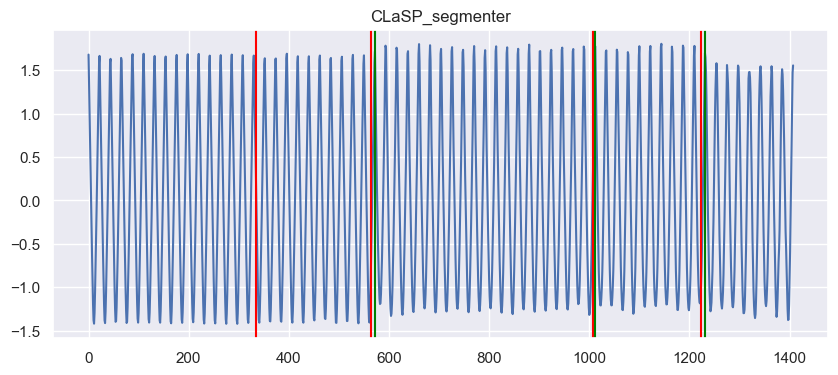

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/kneed/knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))


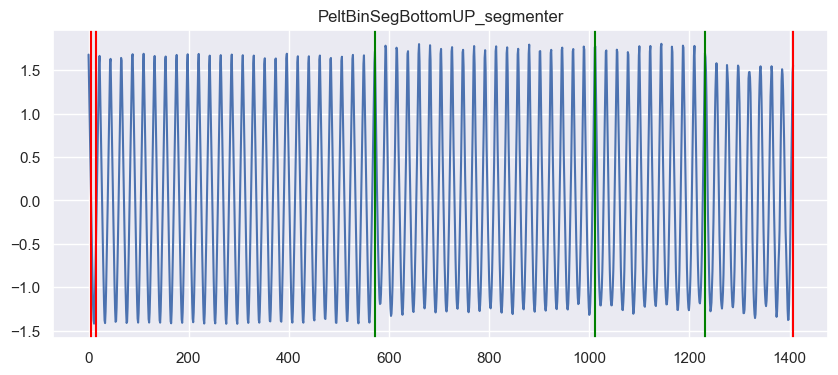

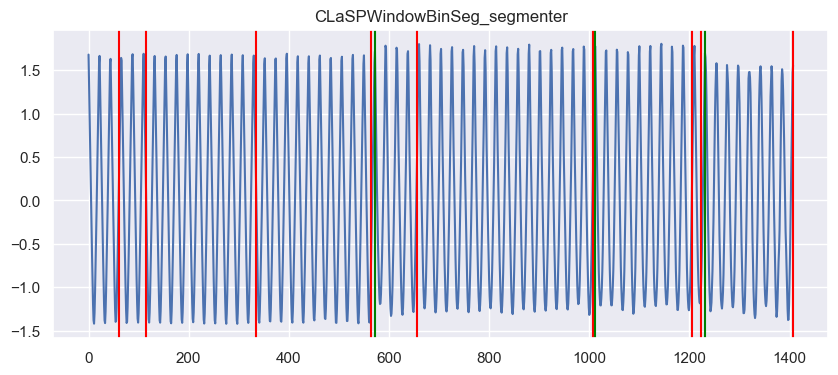

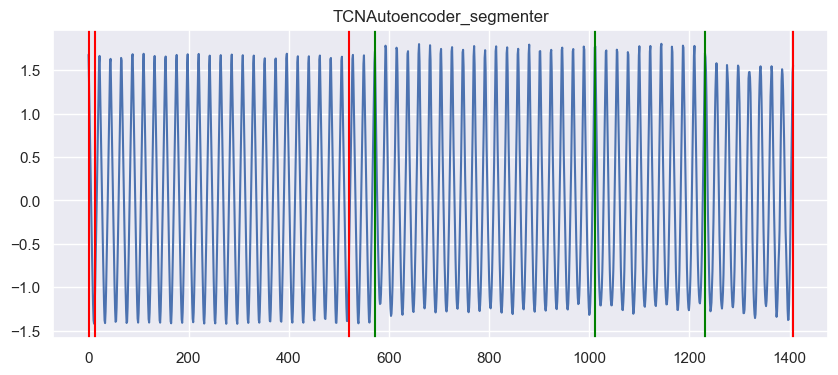

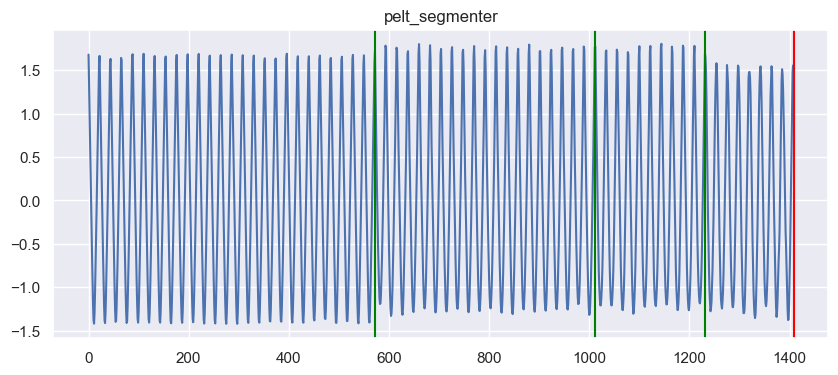

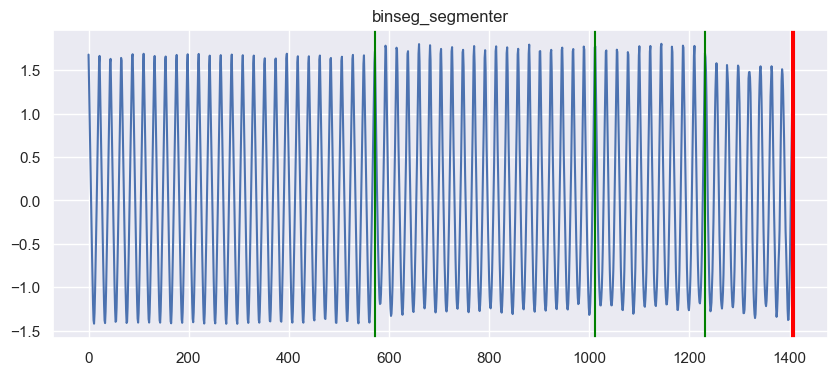

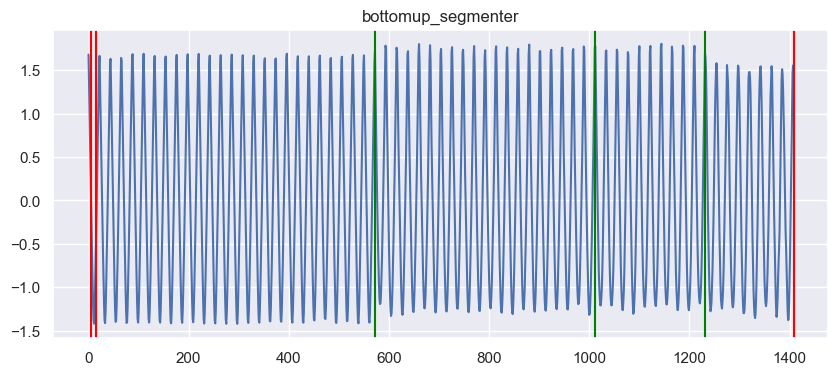

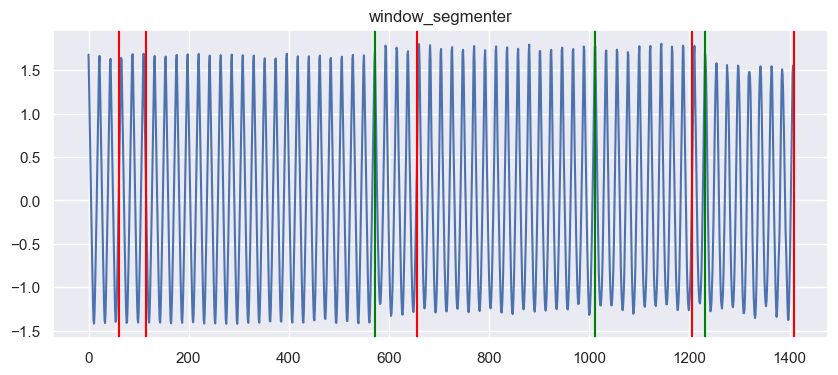

In [108]:
algos = [CLaSP_segmenter, PeltBinSegBottomUP_segmenter, CLaSPWindowBinSeg_segmenter, TCNAutoencoder_segmenter, pelt_segmenter, binseg_segmenter, bottomup_segmenter, window_segmenter]
algo_names = ["CLaSP_segmenter", "PeltBinSegBottomUP_segmenter", "CLaSPWindowBinSeg_segmenter", "TCNAutoencoder_segmenter", "pelt_segmenter", "binseg_segmenter", "bottomup_segmenter", "window_segmenter"]
#ts = ecg_dataset.iloc[20, :-1].values
#ts = np.array(microsoft_stocks_dataset['Open'])
ts = tssb.loc[0, 'time_series']
#ts = has_for_tcnautoencoder.loc[10, 'time_series']

for algo, algo_name in zip(algos, algo_names):
    cps = algo(ts)
    plot_changepoints_on_ts(ts, cps, algo_name, tssb.loc[0, 'change_points'])
    

In [ ]:
calculate_score(tssb, window_segmenter)

100%|██████████| 75/75 [00:02<00:00, 35.55it/s]


0.571954404588221

In [135]:
calculate_score(has_for_tcnautoencoder.iloc[110:140], pelt_segmenter)

100%|██████████| 30/30 [01:11<00:00,  2.37s/it]


0.577730942448072

In [ ]:
calculate_score(tssb, CLaSP_segmenter)

100%|██████████| 75/75 [00:23<00:00,  3.19it/s]


0.8545558856168317

In [ ]:
calculate_score(has_for_tcnautoencoder, window_segmenter)

100%|██████████| 250/250 [00:12<00:00, 20.73it/s]


0.6019443395510106

In [ ]:
calculate_score(has_for_tcnautoencoder, CLaSP_segmenter)

 47%|████▋     | 118/250 [01:02<01:38,  1.34it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(
100%|██████████| 250/250 [05:20<00:00,  1.28s/it]


0.6612691221433274

In [ ]:
calculate_score(has_for_tcnautoencoder, binseg_segmenter)

100%|██████████| 250/250 [00:49<00:00,  5.06it/s]


0.6308197082625985

In [ ]:
calculate_score(has_for_tcnautoencoder, bottomup_segmenter)

100%|██████████| 250/250 [00:42<00:00,  5.83it/s]


0.611074981888805

In [114]:
calculate_score(has_for_tcnautoencoder, CLaSPWindowBinSeg_segmenter)

 47%|████▋     | 118/250 [01:15<01:58,  1.12it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(
100%|██████████| 250/250 [05:30<00:00,  1.32s/it]


0.5624671906251018

In [159]:
calculate_weighted_f1(has_for_tcnautoencoder, CLaSP_segmenter)

 47%|████▋     | 118/250 [01:02<01:36,  1.37it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(
100%|██████████| 250/250 [05:07<00:00,  1.23s/it]


0.7481608041589447

In [160]:
calculate_weighted_f1(has_for_tcnautoencoder, window_segmenter)

100%|██████████| 250/250 [00:11<00:00, 20.85it/s]


0.7278423613232882

In [161]:
calculate_weighted_f1(has_for_tcnautoencoder, binseg_segmenter)

100%|██████████| 250/250 [00:53<00:00,  4.70it/s]


0.7393095265676439

In [162]:
calculate_weighted_f1(has_for_tcnautoencoder, bottomup_segmenter)

100%|██████████| 250/250 [00:41<00:00,  6.01it/s]


0.7028181818605321

In [163]:
segmenters = [window_segmenter, binseg_segmenter, bottomup_segmenter]
calculate_weighted_f1(has_for_tcnautoencoder, lambda ts: ensemble_segmenter(segmenters, ts))

100%|██████████| 250/250 [01:42<00:00,  2.45it/s]


0.5571893443801058

In [164]:
calculate_weighted_f1(tssb, CLaSP_segmenter)

100%|██████████| 75/75 [00:26<00:00,  2.83it/s]


0.8871329196770511

In [165]:
calculate_weighted_f1(tssb, window_segmenter)

100%|██████████| 75/75 [00:02<00:00, 35.16it/s]


0.747081073394465

In [166]:
calculate_weighted_f1(tssb, binseg_segmenter)

100%|██████████| 75/75 [00:19<00:00,  3.89it/s]


0.6694501028895007

In [167]:
calculate_weighted_f1(tssb, bottomup_segmenter)

100%|██████████| 75/75 [00:07<00:00, 10.21it/s]


0.6191587352778435

In [168]:
segmenters = [window_segmenter, binseg_segmenter, bottomup_segmenter]
calculate_weighted_f1(tssb, lambda ts: ensemble_segmenter(segmenters, ts))

100%|██████████| 75/75 [00:28<00:00,  2.64it/s]


0.3918293274420386

# Ensemble modell az idősor statisztikai mutatói alapján

In [38]:
from sklearn.model_selection import train_test_split

all_in_one_timeseries = pd.concat([tssb, has_for_tcnautoencoder])

train_tssb, test_tssb = train_test_split(tssb, test_size=0.4, random_state=42)
train_has, test_has = train_test_split(has_for_tcnautoencoder, test_size=0.4, random_state=42)
train_all, test_all = train_test_split(all_in_one_timeseries, test_size=0.4, random_state=42)

In [39]:
from scipy.stats import linregress, median_abs_deviation
from sklearn.linear_model import TheilSenRegressor
from statsmodels.nonparametric.smoothers_lowess import lowess

def compute_features(ts):
    x = np.arange(len(ts))

    slope_lr, _, _, _, _ = linregress(x, ts)

    rolling_std = pd.Series(ts).rolling(window=10, min_periods=5).std().mean()

    autocorr = acf(ts, nlags=1)[1]

    length = len(ts)

    #mean_abs_change = np.mean(np.abs(np.diff(ts)))

    coefficient_of_variation = np.std(ts) / np.mean(ts) if np.mean(ts) != 0 else 0

    return slope_lr, rolling_std, autocorr, length, coefficient_of_variation


In [40]:
features = []
for ts in tqdm(train_has['time_series']):
    trend, volatility, autocorr, length, cv = compute_features(ts)
    features.append([autocorr, length, cv])

features_df = pd.DataFrame(features, columns=[
    "autocorr", "length", "cv"
])

100%|██████████| 150/150 [00:00<00:00, 1391.00it/s]


In [41]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

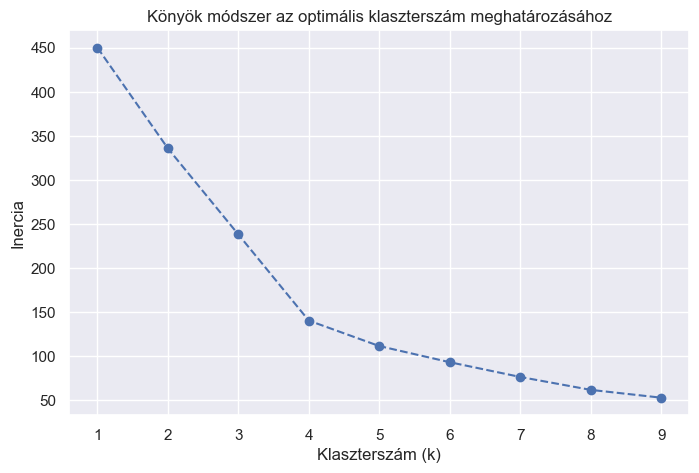

In [42]:
inertia = []
k_values = range(1, 10)  # Klaszterszámokat 1-től 10-ig vizsgáljuk

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker="o", linestyle="--", color="b")
plt.xlabel("Klaszterszám (k)")
plt.ylabel("Inercia")
plt.title("Könyök módszer az optimális klaszterszám meghatározásához")
plt.show()

In [43]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
features_df["Cluster"] = kmeans.fit_predict(features_scaled)

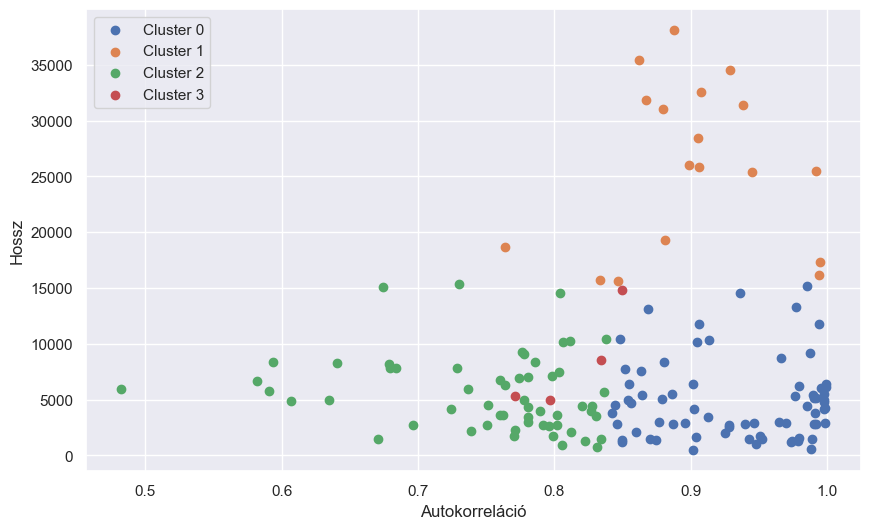

In [44]:
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    subset = features_df[features_df["Cluster"] == cluster]
    plt.scatter(subset["autocorr"], subset["length"], label=f"Cluster {cluster}")
    plt.xlabel("Autokorreláció")
    plt.ylabel("Hossz")
    plt.legend()
#plt.axhline(y=17000, color='r', linestyle='--', label="Hossz küszöb")
plt.show()

In [45]:
#train_tssb['cluster'] = features_df['Cluster'].values
train_has['cluster'] = features_df['Cluster'].values
#all_in_one_timeseries['cluster'] = features_df['Cluster'].values

In [46]:
# train_tssb_cluster0 = train_tssb[train_tssb['cluster'] == 0].copy().reset_index(drop=True)
# train_tssb_cluster1 = train_tssb[train_tssb['cluster'] == 1].copy().reset_index(drop=True)
# train_tssb_cluster2 = train_tssb[train_tssb['cluster'] == 2].copy().reset_index(drop=True)

train_has_cluster0 = train_has[train_has['cluster'] == 0].copy().reset_index(drop=True)
train_has_cluster1 = train_has[train_has['cluster'] == 1].copy().reset_index(drop=True)
train_has_cluster2 = train_has[train_has['cluster'] == 2].copy().reset_index(drop=True)
train_has_cluster3 = train_has[train_has['cluster'] == 3].copy().reset_index(drop=True)

# all_in_one_timeseries_cluster0 = all_in_one_timeseries[all_in_one_timeseries['cluster'] == 0].copy().reset_index(drop=True)
# all_in_one_timeseries_cluster1 = all_in_one_timeseries[all_in_one_timeseries['cluster'] == 1].copy().reset_index(drop=True)
# all_in_one_timeseries_cluster2 = all_in_one_timeseries[all_in_one_timeseries['cluster'] == 2].copy().reset_index(drop=True)

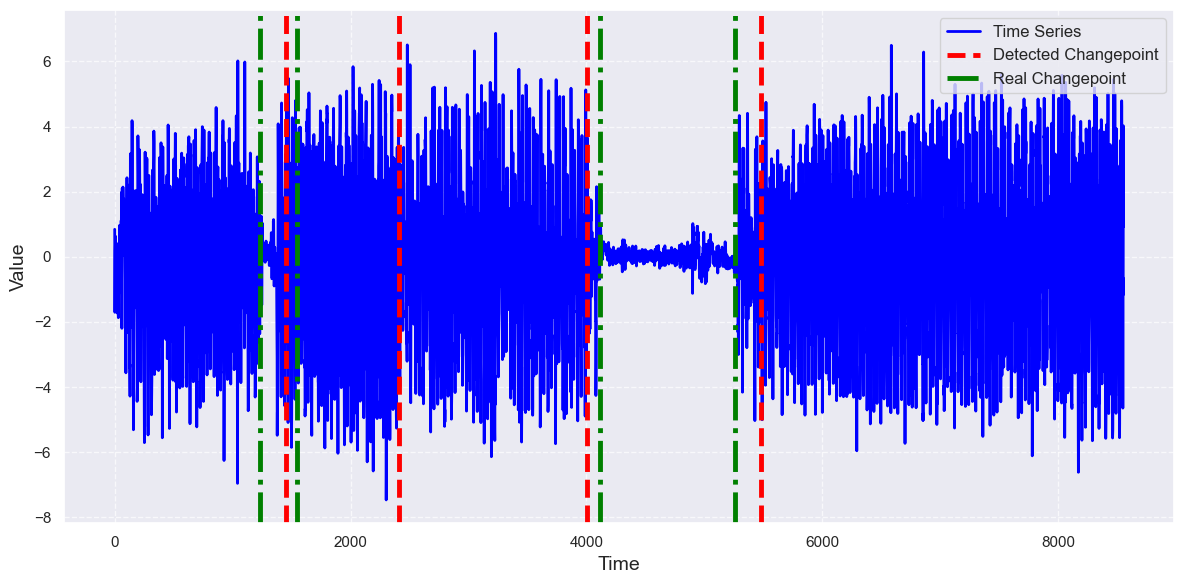

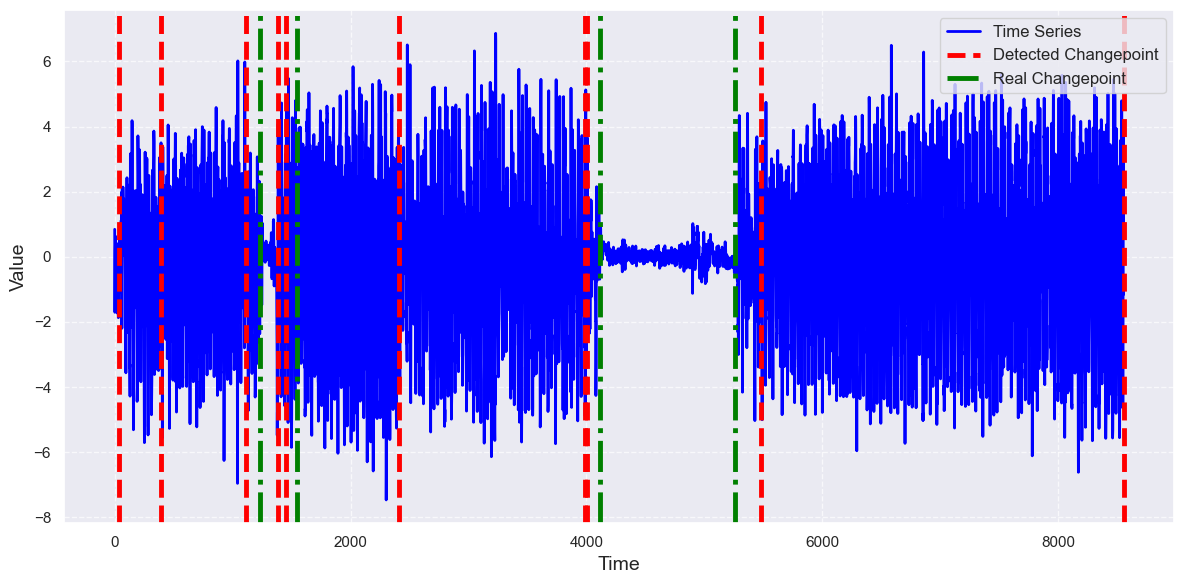

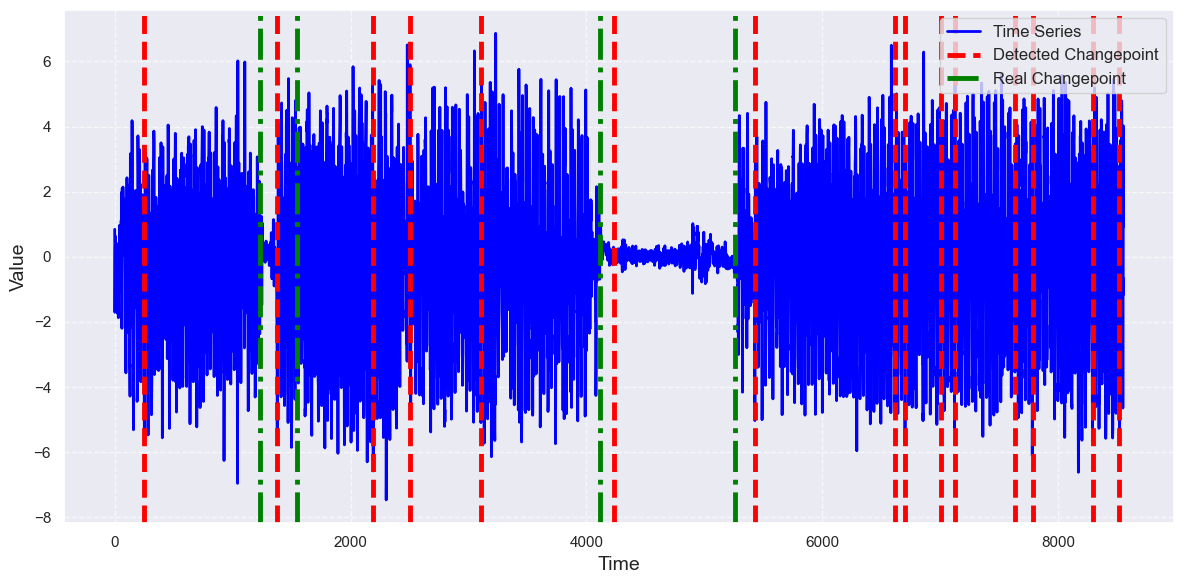

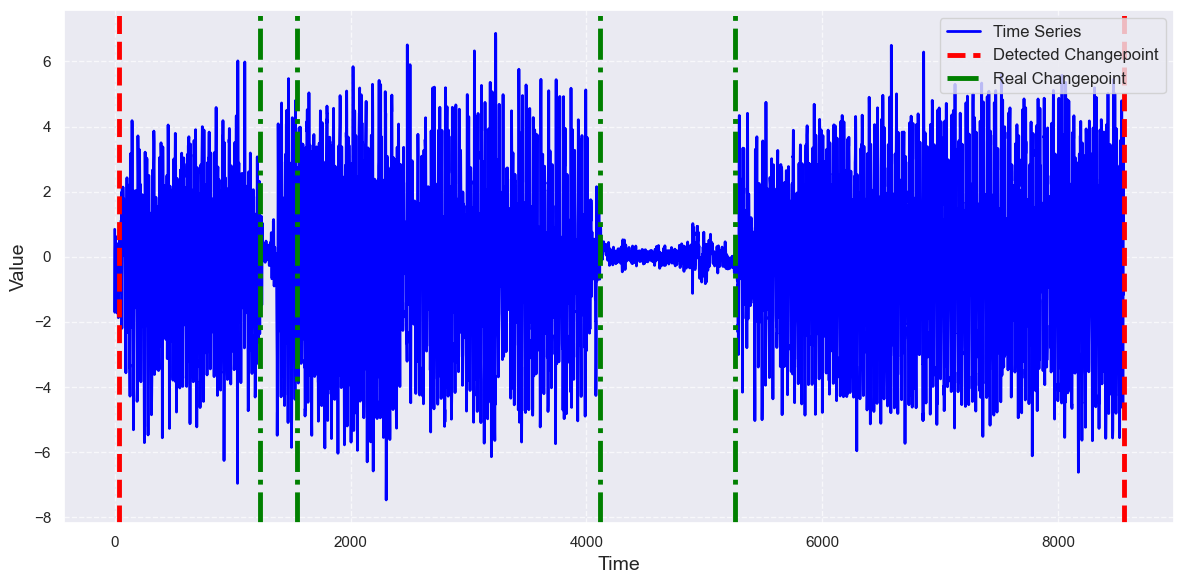

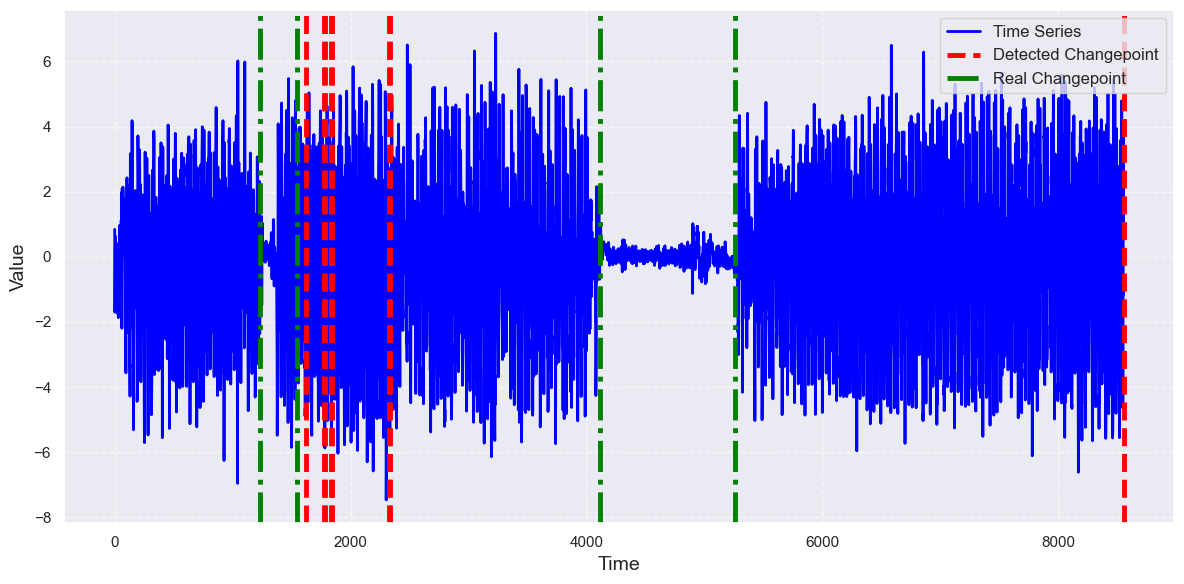

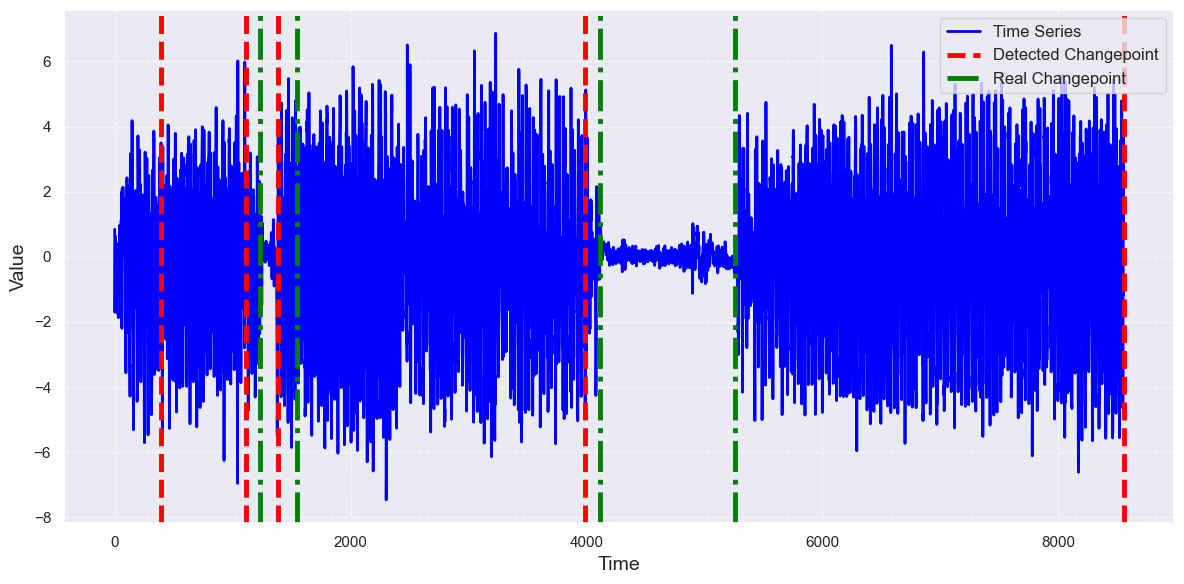

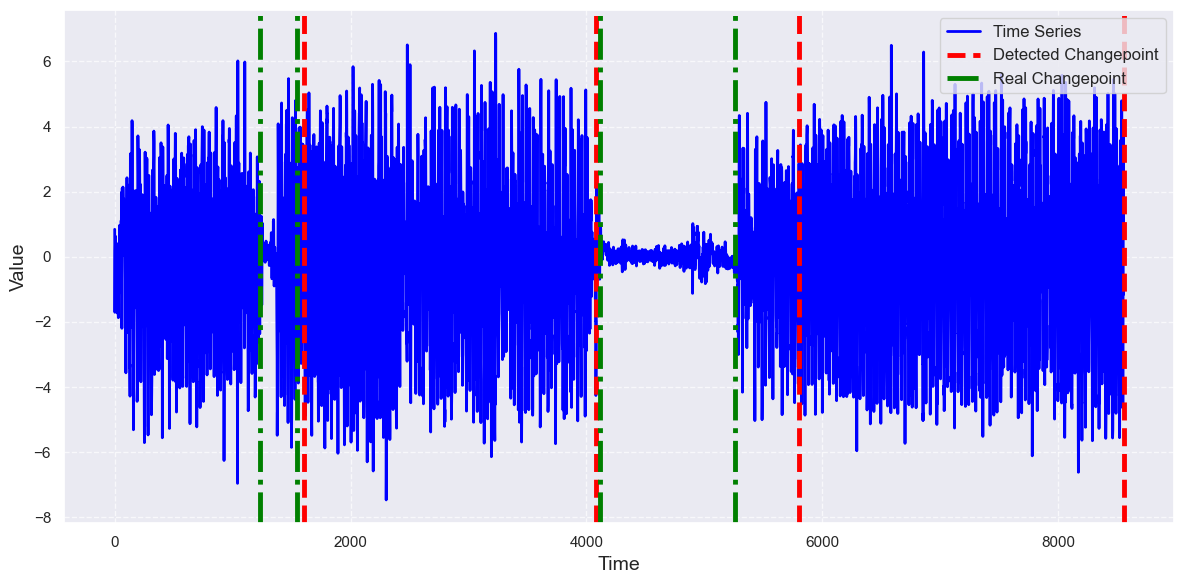

In [85]:
algos = [CLaSP_segmenter, CLaSPWindowBinSeg_segmenter, TCNAutoencoder_segmenter, binseg_segmenter, bottomup_segmenter, window_segmenter, pelt_segmenter]
algo_names = ["CLaSP_segmenter", "CLaSPWindowBinSeg_segmenter", "TCNAutoencoder_segmenter", "binseg_segmenter", "bottomup_segmenter", "window_segmenter", "pelt_segmenter"]



#ts = train_tssb_cluster0.loc[1, 'time_series']
#ts =train_tssb_cluster1.loc[0, 'time_series']
#ts = train_tssb_cluster2.loc[0, 'time_series']

#ts = train_has_cluster0.loc[1, 'time_series']
#ts = train_has_cluster1.loc[2, 'time_series']
#ts = train_has_cluster2.loc[0, 'time_series']
ts = train_has_cluster3.loc[1, 'time_series']

#ts = all_in_one_timeseries_cluster0.loc[0, 'time_series']
#ts = all_in_one_timeseries_cluster1.loc[3, 'time_series']
#ts = all_in_one_timeseries_cluster2.loc[0, 'time_series']

for algo, algo_name in zip(algos, algo_names):
    cps = algo(ts)
    plot_changepoints_on_ts(ts, cps, algo_name, train_has_cluster3.loc[1, 'change_points'])

In [159]:
calculate_score(train_has_cluster3, CLaSP_segmenter)

100%|██████████| 4/4 [00:02<00:00,  1.35it/s]


0.725677934946752

In [117]:
calculate_score(train_has_cluster3, CLaSPWindowBinSeg_segmenter)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


0.6151544396536869

In [160]:
calculate_score(train_has_cluster3, TCNAutoencoder_segmenter)

100%|██████████| 4/4 [00:11<00:00,  2.87s/it]


0.49760810639324604

In [123]:
calculate_score(tssb, binseg_segmenter)

100%|██████████| 75/75 [00:18<00:00,  3.97it/s]


0.39317200625390214

In [125]:
calculate_score(tssb, bottomup_segmenter)

  0%|          | 0/75 [00:00<?, ?it/s]

100%|██████████| 75/75 [00:07<00:00, 10.69it/s]


0.514461438532852

In [127]:
calculate_score(has_for_tcnautoencoder, window_segmenter)  

100%|██████████| 250/250 [00:11<00:00, 21.97it/s]


0.6019443395510106

In [124]:
algos = [bottomup_segmenter, binseg_segmenter]
calculate_score(tssb, lambda ts: ensemble_segmenter(algos, ts))

100%|██████████| 75/75 [00:26<00:00,  2.85it/s]


0.49765211507922763

In [86]:
segmenters = [bottomup_segmenter, binseg_segmenter, window_segmenter]
calculate_score(train_has_cluster1, lambda ts: ensemble_segmenter(segmenters, ts))

100%|██████████| 18/18 [00:28<00:00,  1.58s/it]


0.5303957273449444

In [47]:
centroids = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids)


boundaries = {}
for i in range(optimal_k - 1):
    for j in range(i + 1, optimal_k):
        midpoint = (centroids[i] + centroids[j]) / 2
        boundaries[f"Boundary {i}-{j}"] = midpoint

boundary_df = pd.DataFrame(boundaries).T
boundary_df.columns = features_df.columns[:-1]

In [48]:
boundary_df

autocorr        length          cv
Boundary 0-1  0.917403  15455.141628   -1.596701
Boundary 0-2  0.842511   5215.758587    0.629283
Boundary 0-3  0.873061   6635.697183 -255.923073
Boundary 1-2  0.826905  15807.505848    0.807668
Boundary 1-3  0.857456  17227.444444 -255.744689
Boundary 2-3  0.782563   6988.061404 -253.518705

In [49]:
def statistical_ensemble_segmenter(ts):
    slope_lr, rolling_std, autocorr, length = compute_features(ts)

    if length > 17000:
        return binseg_segmenter(ts)
    else:
        return CLaSP_segmenter(ts)

In [69]:
calculate_score(all_in_one_timeseries, statistical_ensemble_segmenter)

 59%|█████▉    | 193/325 [01:17<01:42,  1.29it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(
100%|██████████| 325/325 [02:10<00:00,  2.49it/s]


0.7070843777966405

In [70]:
calculate_score(all_in_one_timeseries, CLaSP_segmenter)

 59%|█████▉    | 193/325 [01:29<01:37,  1.36it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(
100%|██████████| 325/325 [05:38<00:00,  1.04s/it]


0.7058737598679826

In [132]:
test_tssb.shape

(30, 4)

# Végleges algoritmus

In [50]:
from sklearn.decomposition import PCA

def model_preprocessing(train_set):
    features = []
    for ts in tqdm(train_set['time_series']):
        trend, volatility, autocorr, length, cv = compute_features(ts)
        features.append([autocorr, length, cv])

    features_df = pd.DataFrame(features, columns=[
        "autocorr", "length", "cv"
    ])

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_df)

    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    features_df["Cluster"] = kmeans.fit_predict(features_scaled)

    train_set['cluster'] = features_df['Cluster'].values

    train_cluster0 = train_set[train_set['cluster'] == 0].copy().reset_index(drop=True)
    train_cluster1 = train_set[train_set['cluster'] == 1].copy().reset_index(drop=True)
    train_cluster2 = train_set[train_set['cluster'] == 2].copy().reset_index(drop=True)
    train_cluster3 = train_set[train_set['cluster'] == 3].copy().reset_index(drop=True)

    clustered_data = [train_cluster0, train_cluster1, train_cluster2, train_cluster3]

    pca = PCA(n_components=2)
    features_pca = pca.fit_transform(features_scaled)


    plt.figure(figsize=(10, 6))
    for cluster in range(optimal_k):
        cluster_points = features_pca[features_df["Cluster"] == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")
    plt.xlabel("PCA 1. komponens")
    plt.ylabel("PCA 2. komponens")
    plt.title("Klaszterek PCA 2D vetítésben")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("pca_plot.png", dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 6))
    for cluster in range(optimal_k):
        subset = features_df[features_df["Cluster"] == cluster]
        plt.scatter(subset["length"], subset["autocorr"], label=f"Cluster {cluster}")
        plt.ylabel("Autokorreláció")
        plt.xlabel("Hossz")
        plt.legend()
    plt.savefig("hossz_autocorr.png", dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 6))
    for cluster in range(optimal_k):
        subset = features_df[features_df["Cluster"] == cluster]
        plt.scatter(subset["length"], subset["cv"], label=f"Cluster {cluster}")
        plt.xlabel("Hosssz")
        plt.ylabel("Variációs kovariancia")
        plt.legend()
    plt.savefig("hossz_cv.png", dpi=300, bbox_inches='tight')
    plt.show()

    return clustered_data, kmeans, scaler        

In [51]:
def calc_models_for_clusters(clustered_data):
    algos = [CLaSP_segmenter, window_segmenter, binseg_segmenter, bottomup_segmenter]

    algo_for_cluster = {}
    for train_cluster in clustered_data:
        scores = []
        for algo in algos:
            score = calculate_f1(train_cluster, algo)
            scores.append(score)
        best_algo = algos[np.argmax(scores)]
        algo_for_cluster[train_cluster['cluster'].iloc[0]] = best_algo

    return algo_for_cluster

In [52]:
def my_ensemble_covering(test_set, kmeans, scaler, algo_for_cluster):
    features = []
    for ts in tqdm(test_set['time_series']):
        trend, volatility, autocorr, length, cv = compute_features(ts)
        features.append([autocorr, length, cv])

    features_df = pd.DataFrame(features, columns=[
        "autocorr", "length", "cv"
    ])

    features_scaled = scaler.transform(features_df)

    test_set['cluster'] = kmeans.predict(features_scaled)

    test_cluster0 = test_set[test_set['cluster'] == 0].copy().reset_index(drop=True)
    test_cluster1 = test_set[test_set['cluster'] == 1].copy().reset_index(drop=True)
    test_cluster2 = test_set[test_set['cluster'] == 2].copy().reset_index(drop=True)
    test_cluster3 = test_set[test_set['cluster'] == 3].copy().reset_index(drop=True)

    test_clustered_data = [test_cluster0, test_cluster1, test_cluster2, test_cluster3]

    scores = []
    weights = []

    for test_cluster in test_clustered_data:
        if test_cluster.empty:
            continue
        algo = algo_for_cluster[test_cluster['cluster'].iloc[0]]
        score = calculate_score(test_cluster, algo)
        scores.append(score)
        weights.append(len(test_cluster))

    return np.average(scores, weights=weights)


def my_ensemble_weighted_f1(test_set, kmeans, scaler, algo_for_cluster):
    features = []
    for ts in tqdm(test_set['time_series']):
        trend, volatility, autocorr, length, cv = compute_features(ts)
        features.append([autocorr, length, cv])

    features_df = pd.DataFrame(features, columns=[
        "autocorr", "length", "cv"
    ])

    features_scaled = scaler.transform(features_df)

    test_set['cluster'] = kmeans.predict(features_scaled)

    test_cluster0 = test_set[test_set['cluster'] == 0].copy().reset_index(drop=True)
    test_cluster1 = test_set[test_set['cluster'] == 1].copy().reset_index(drop=True)
    test_cluster2 = test_set[test_set['cluster'] == 2].copy().reset_index(drop=True)
    test_cluster3 = test_set[test_set['cluster'] == 3].copy().reset_index(drop=True)

    test_clustered_data = [test_cluster0, test_cluster1, test_cluster2, test_cluster3]

    scores = []
    weights = []

    for test_cluster in test_clustered_data:
        if test_cluster.empty:
            continue
        algo = algo_for_cluster[test_cluster['cluster'].iloc[0]]
        score = calculate_weighted_f1(test_cluster, algo)
        
        total_cluster_length = sum(len(row['time_series']) for _, row in test_cluster.iterrows())
        
        scores.append(score)
        weights.append(total_cluster_length)

    return np.average(scores, weights=weights)


def my_ensemble_f1(test_set, kmeans, scaler, algo_for_cluster):
    features = []
    for ts in tqdm(test_set['time_series']):
        trend, volatility, autocorr, length, cv = compute_features(ts)
        features.append([autocorr, length, cv])

    features_df = pd.DataFrame(features, columns=[
        "autocorr", "length", "cv"
    ])

    features_scaled = scaler.transform(features_df)

    test_set['cluster'] = kmeans.predict(features_scaled)

    test_cluster0 = test_set[test_set['cluster'] == 0].copy().reset_index(drop=True)
    test_cluster1 = test_set[test_set['cluster'] == 1].copy().reset_index(drop=True)
    test_cluster2 = test_set[test_set['cluster'] == 2].copy().reset_index(drop=True)
    test_cluster3 = test_set[test_set['cluster'] == 3].copy().reset_index(drop=True)

    test_clustered_data = [test_cluster0, test_cluster1, test_cluster2, test_cluster3]

    scores = []
    weights = []

    for test_cluster in test_clustered_data:
        if test_cluster.empty:
            continue
        algo = algo_for_cluster[test_cluster['cluster'].iloc[0]]
        score = calculate_f1(test_cluster, algo)
        
        scores.append(score)
        weights.append(len(test_cluster))

    return np.average(scores, weights=weights)
    

HAS-on eredmény

100%|██████████| 45/45 [00:00<00:00, 1024.28it/s]


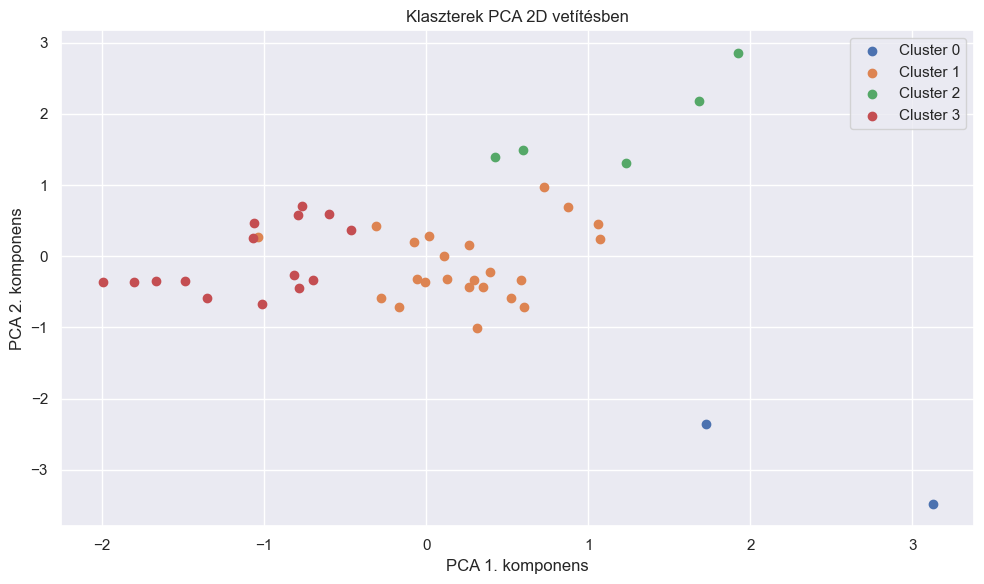

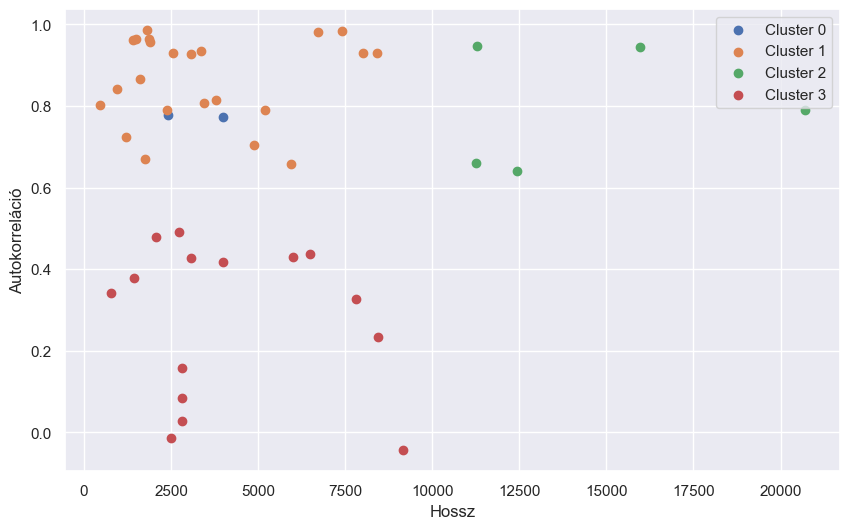

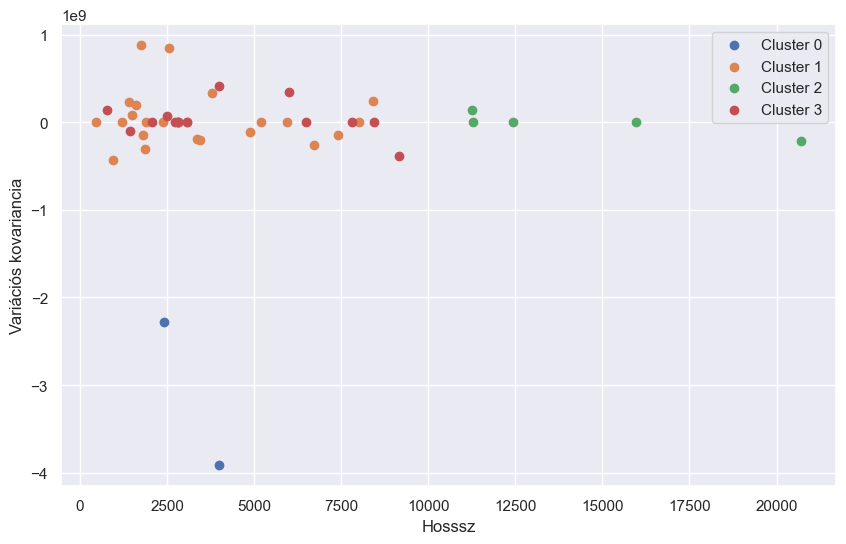

In [69]:
clustered_data, kmeans, scaler  = model_preprocessing(train_tssb)

In [70]:
algo_for_cluster = calc_models_for_clusters(clustered_data)

100%|██████████| 15/15 [00:01<00:00, 11.52it/s]


In [71]:
accuracy_on_test = my_ensemble_f1(test_tssb, kmeans, scaler, algo_for_cluster)
accuracy_on_test

100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


np.float64(0.8922607022607024)

In [73]:
algos = [CLaSPWindowBinSeg_segmenter, PeltBinSegBottomUP_segmenter, CLaSP_segmenter, TCNAutoencoder_segmenter, binseg_segmenter, bottomup_segmenter, window_segmenter, pelt_segmenter]
algo_names = ["CLaSPWindowBinSeg_segmenter", "PeltBinSegBottomUP_segmenter", "CLaSP_segmenter", "TCNAutoencoder_segmenter", "binseg_segmenter", "bottomup_segmenter", "window_segmenter", "pelt_segmenter"]

datasets = [test_tssb, test_has]
dataset_names = ["test_tssb", "test_has"]

for dataset, dataset_name in zip(datasets, dataset_names):
    print(f"Dataset: {dataset_name}")
    for algo, algo_name in zip(algos, algo_names):
        print(f"F1 score for {algo_name}: {calculate_f1(dataset, algo)}")
    print("----------------------------------------------------------------------")

Dataset: test_tssb


100%|██████████| 30/30 [00:18<00:00,  1.64it/s]


F1 score for CLaSPWindowBinSeg_segmenter: 0.41567454232550477


  3%|▎         | 1/30 [00:02<01:10,  2.41s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/kneed/knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))
100%|██████████| 30/30 [07:51<00:00, 15.73s/it]


F1 score for PeltBinSegBottomUP_segmenter: 0.3951027967902813


100%|██████████| 30/30 [00:09<00:00,  3.09it/s]


F1 score for CLaSP_segmenter: 0.8922607022607024


100%|██████████| 30/30 [03:02<00:00,  6.07s/it]


F1 score for TCNAutoencoder_segmenter: 0.4876399761150814


100%|██████████| 30/30 [00:07<00:00,  3.99it/s]


F1 score for binseg_segmenter: 0.6663793396146338


100%|██████████| 30/30 [00:02<00:00, 11.37it/s]


F1 score for bottomup_segmenter: 0.577211677211677


100%|██████████| 30/30 [00:00<00:00, 37.81it/s]


F1 score for window_segmenter: 0.706623289564466


  3%|▎         | 1/30 [00:02<01:00,  2.10s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/kneed/knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))
100%|██████████| 30/30 [07:42<00:00, 15.42s/it]


F1 score for pelt_segmenter: 0.6482515632515632
----------------------------------------------------------------------
Dataset: test_has


 39%|███▉      | 39/100 [01:13<06:35,  6.49s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/claspy/segmentation.py:212: UserWarning: Time series must at least have 2*min_seg_size data points for segmentation. Try setting a smaller window size.
  warnings.warn(
100%|██████████| 100/100 [02:12<00:00,  1.32s/it]


F1 score for CLaSPWindowBinSeg_segmenter: 0.5052934606093771


100%|██████████| 100/100 [05:14<00:00,  3.14s/it]


F1 score for PeltBinSegBottomUP_segmenter: 0.45050340272448336


100%|██████████| 100/100 [01:53<00:00,  1.13s/it]


F1 score for CLaSP_segmenter: 0.7401953192146687


100%|██████████| 100/100 [18:41<00:00, 11.21s/it]


F1 score for TCNAutoencoder_segmenter: 0.442504655250164


100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


F1 score for binseg_segmenter: 0.6819066095172226


100%|██████████| 100/100 [00:16<00:00,  6.20it/s]


F1 score for bottomup_segmenter: 0.6028876583512803


100%|██████████| 100/100 [00:04<00:00, 21.96it/s]


F1 score for window_segmenter: 0.7120801371830779


100%|██████████| 100/100 [04:37<00:00,  2.78s/it]

F1 score for pelt_segmenter: 0.7286966921966915
----------------------------------------------------------------------


In [64]:
segmenters = [window_segmenter, binseg_segmenter, bottomup_segmenter]
point = calculate_f1(test_has, lambda ts: ensemble_segmenter(segmenters, ts))
print(f"WindowBinSegBottomUp HAS f1 Score: {point}")


point = calculate_f1(test_tssb, lambda ts: ensemble_segmenter(segmenters, ts))
print(f"WindowBinSegBottomUp TSSB f1 Score: {point}")

100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


WindowBinSegBottomUp HAS f1 Score: 0.4482971703386271


100%|██████████| 30/30 [00:11<00:00,  2.54it/s]

WindowBinSegBottomUp TSSB f1 Score: 0.3519626806590059


In [72]:
algo_for_cluster

{np.int32(0): <function __main__.CLaSP_segmenter(ts)>,
 np.int32(1): <function __main__.CLaSP_segmenter(ts)>,
 np.int32(2): <function __main__.CLaSP_segmenter(ts)>,
 np.int32(3): <function __main__.CLaSP_segmenter(ts)>}

In [156]:
calculate_score(train_tssb, binseg_segmenter)

100%|██████████| 45/45 [00:11<00:00,  3.82it/s]


0.4110702847431604

In [201]:
calculate_weighted_f1(test_tssb, CLaSP_segmenter)

100%|██████████| 30/30 [00:09<00:00,  3.27it/s]


0.8889708950853191

In [81]:
calculate_score(test_tssb, pelt_segmenter)

  3%|▎         | 1/30 [00:02<01:01,  2.12s/it]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/kneed/knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))
100%|██████████| 30/30 [07:44<00:00, 15.49s/it]


0.42149942169863136

In [82]:
calculate_score(test_has, pelt_segmenter)

  0%|          | 0/100 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/kneed/knee_locator.py:225: RuntimeWarning: invalid value encountered in divide
  return (a - min(a)) / (max(a) - min(a))
100%|██████████| 100/100 [04:39<00:00,  2.79s/it]


0.5758696843058174

In [83]:
calculate_weighted_f1(test_tssb, pelt_segmenter)

100%|██████████| 30/30 [07:41<00:00, 15.37s/it]


0.6400484046484824

In [84]:
calculate_weighted_f1(test_has, pelt_segmenter)

100%|██████████| 100/100 [04:38<00:00,  2.79s/it]


0.7831552161167051

In [100]:
calculate_weighted_f1(test_tssb, binseg_segmenter)

100%|██████████| 30/30 [00:07<00:00,  4.09it/s]


0.6559674494359712

TSSB-n eredmény

In [119]:
clustered_data, kmeans, scaler  = model_preprocessing(train_tssb)

100%|██████████| 45/45 [00:00<00:00, 1100.46it/s]


In [120]:
algo_for_cluster = calc_models_for_clusters(clustered_data)

100%|██████████| 5/5 [00:21<00:00,  4.39s/it]


In [121]:
accuracy_on_test = my_ensemble(test_tssb, kmeans, scaler, algo_for_cluster)
accuracy_on_test

100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


np.float64(0.9031441647425454)


# Egyes klasztereken mért eredmények

100%|██████████| 150/150 [00:00<00:00, 1547.17it/s]


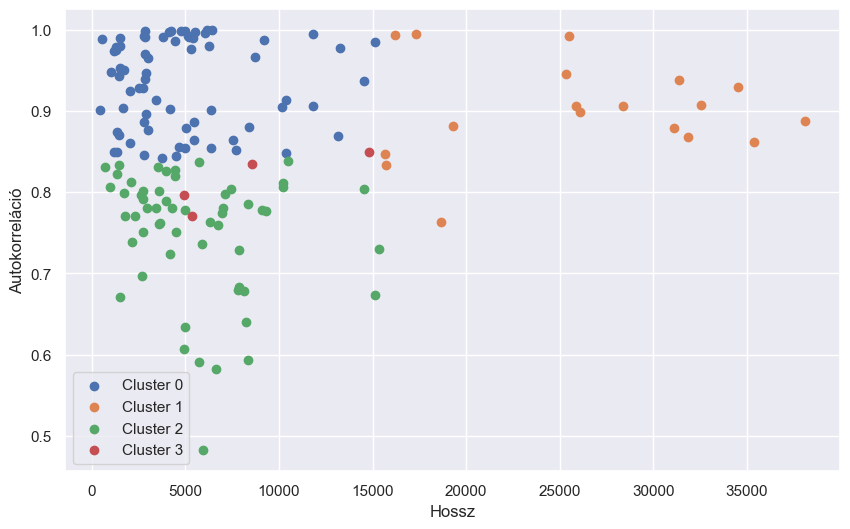

In [53]:
train_set = train_has.copy()

features = []
for ts in tqdm(train_set['time_series']):
    trend, volatility, autocorr, length, cv = compute_features(ts)
    features.append([autocorr, length, cv])

features_df = pd.DataFrame(features, columns=[
    "autocorr", "length", "cv"
])

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)

optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
features_df["Cluster"] = kmeans.fit_predict(features_scaled)

train_set['cluster'] = features_df['Cluster'].values

train_cluster0 = train_set[train_set['cluster'] == 0].copy().reset_index(drop=True)
train_cluster1 = train_set[train_set['cluster'] == 1].copy().reset_index(drop=True)
train_cluster2 = train_set[train_set['cluster'] == 2].copy().reset_index(drop=True)
train_cluster3 = train_set[train_set['cluster'] == 3].copy().reset_index(drop=True)

clustered_data = [train_cluster0, train_cluster1, train_cluster2, train_cluster3]

plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    subset = features_df[features_df["Cluster"] == cluster]
    plt.scatter(subset["length"], subset["autocorr"], label=f"Cluster {cluster}")
    plt.ylabel("Autokorreláció")
    plt.xlabel("Hossz")
    plt.legend()
plt.savefig("hossz_autocorr.png", dpi=300, bbox_inches='tight')
plt.show()

In [55]:
algos = [CLaSP_segmenter, window_segmenter, binseg_segmenter, bottomup_segmenter, TCNAutoencoder_segmenter]

algo_names = [algo.__name__ for algo in algos]
cluster_ids = [df['cluster'].iloc[0] for df in clustered_data]

score_matrix = pd.DataFrame(index=cluster_ids, columns=algo_names)

algo_for_cluster = {}
for i, train_cluster in enumerate(clustered_data):
    scores = []
    for algo in algos:
        score = calculate_weighted_f1(train_cluster, algo)
        score_matrix.loc[train_cluster['cluster'].iloc[0], algo.__name__] = score
        scores.append(score)
    best_algo = algos[np.argmax(scores)]
    algo_for_cluster[train_cluster['cluster'].iloc[0]] = best_algo

100%|██████████| 4/4 [00:45<00:00, 11.25s/it]


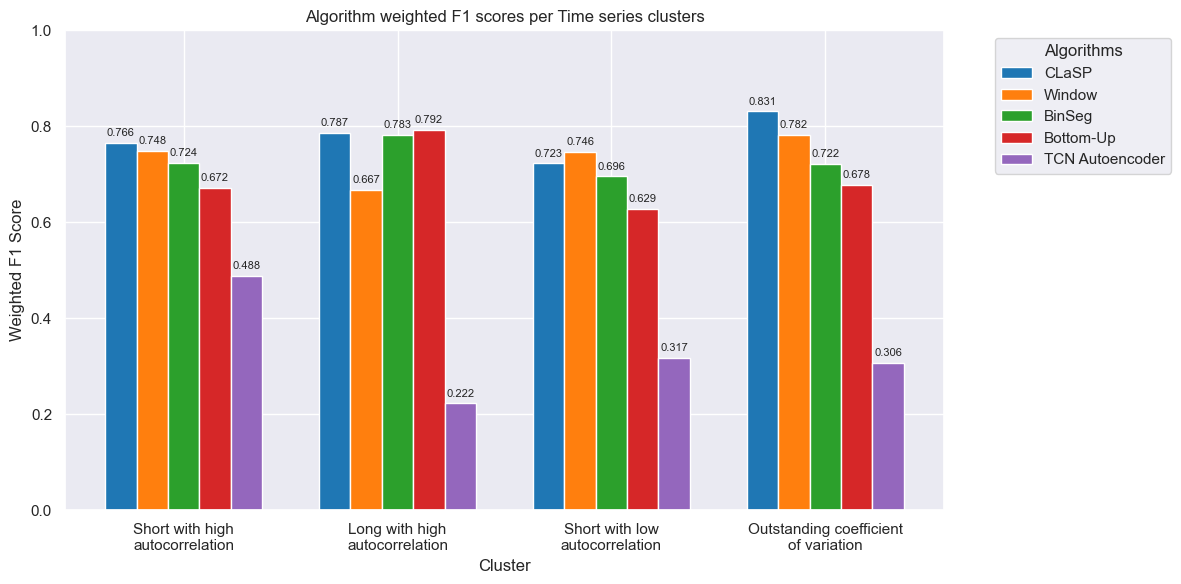

In [56]:
# Step 3: Plot grouped bar chart with spacing between clusters and custom legend labels
score_matrix = score_matrix.astype(float)
bar_width = 0.22
cluster_spacing = 0.4  # extra space between clusters

n_clusters = len(score_matrix.index)
n_algos = len(score_matrix.columns)
group_width = n_algos * bar_width + cluster_spacing

# New x positions: centers of each cluster group
x = np.arange(n_clusters) * group_width

plt.figure(figsize=(12, 6))
colors = plt.cm.tab10.colors

# Custom legend labels for the algorithms
custom_labels = ['CLaSP', 'Window', 'BinSeg', 'Bottom-Up', 'TCN Autoencoder']

custom_cluster_names = [
    'Short with high\nautocorrelation', 
    'Long with high\nautocorrelation', 
    'Short with low\nautocorrelation', 
    'Outstanding coefficient\nof variation'
]
# Plot each algorithm's bars with appropriate shift
for i, algo in enumerate(score_matrix.columns):
    scores = score_matrix[algo]
    bar_positions = x + i * bar_width
    bars = plt.bar(bar_positions, scores, width=bar_width, label=custom_labels[i], color=colors[i % len(colors)])
    
    # Add score labels
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01,
            f"{height:.3f}",
            ha='center',
            va='bottom',
            fontsize=8
        )

# Axis and legend formatting
plt.xlabel("Cluster")
plt.ylabel("Weighted F1 Score")
plt.title("Algorithm weighted F1 scores per Time series clusters")
plt.ylim(0, 1)

# Adjust x-ticks to be centered under cluster groups
plt.xticks(x + (n_algos - 1) * bar_width / 2, custom_cluster_names)

# Place legend outside the plot with custom labels
plt.legend(title="Algorithms", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("cluster_algo_scores_grouped_custom_legend.png", dpi=300, bbox_inches='tight')
plt.show()


In [57]:
algo_for_cluster

{np.int32(0): <function __main__.CLaSP_segmenter(ts)>,
 np.int32(1): <function __main__.bottomup_segmenter(ts, model='l2')>,
 np.int32(2): <function __main__.window_segmenter(ts, model='l2', width=None)>,
 np.int32(3): <function __main__.CLaSP_segmenter(ts)>}

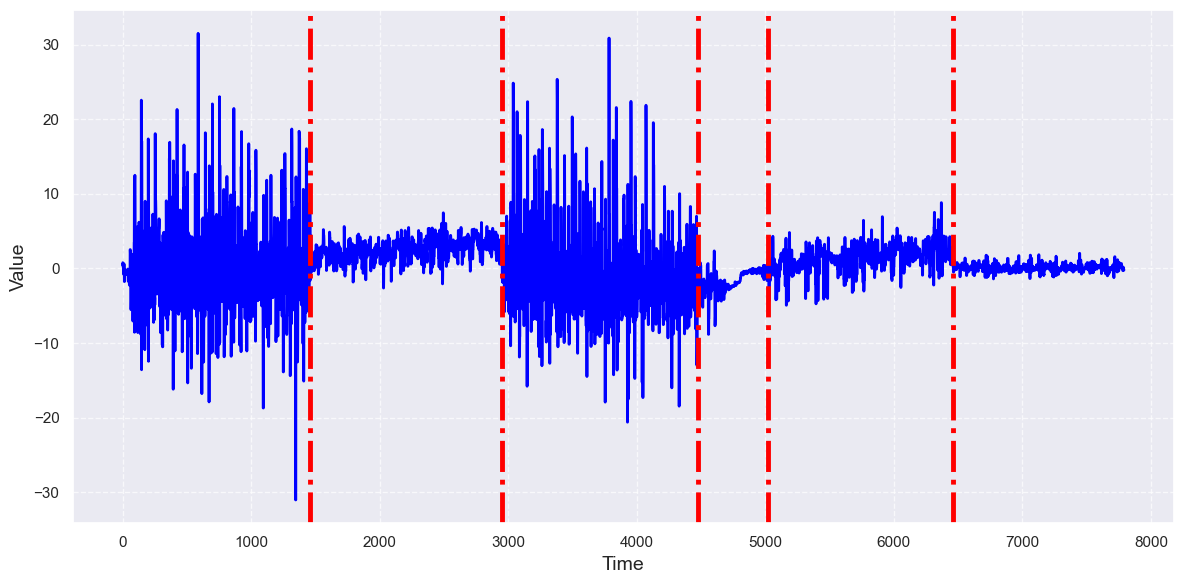

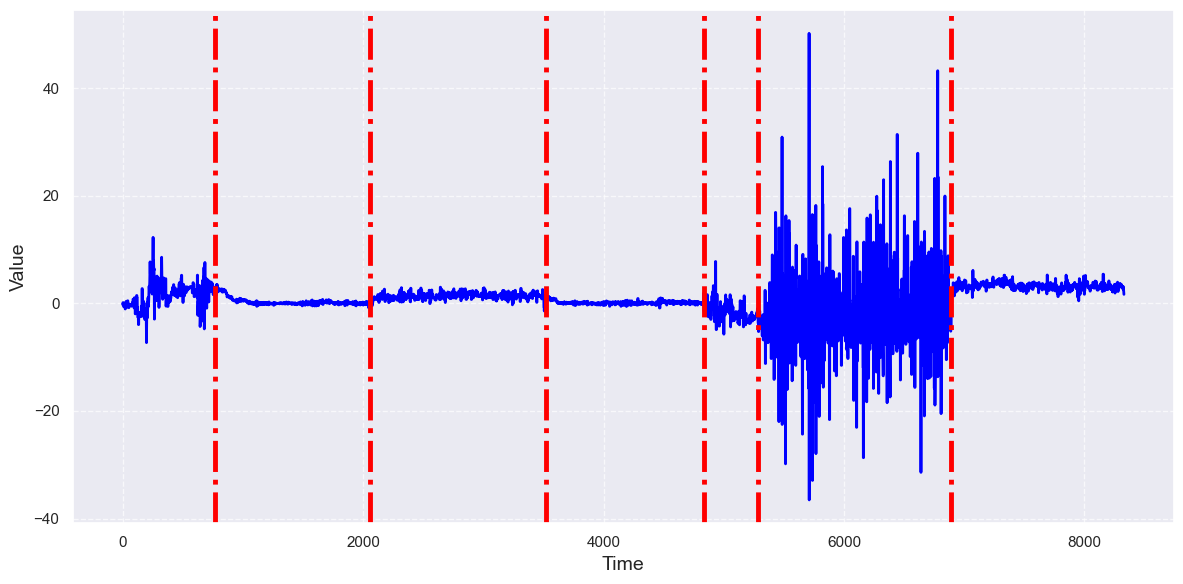

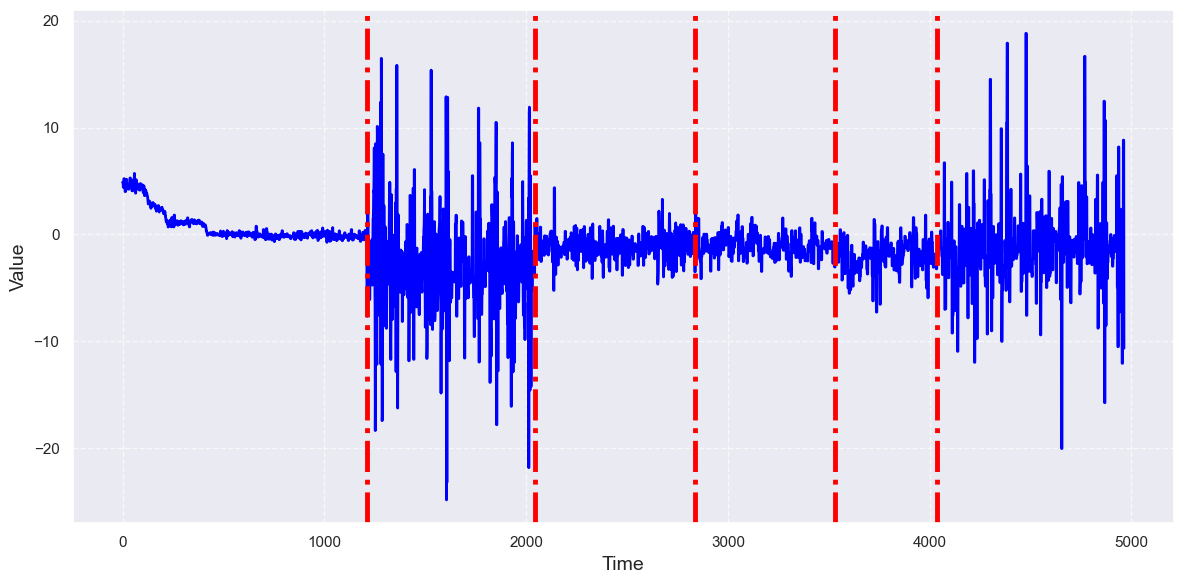

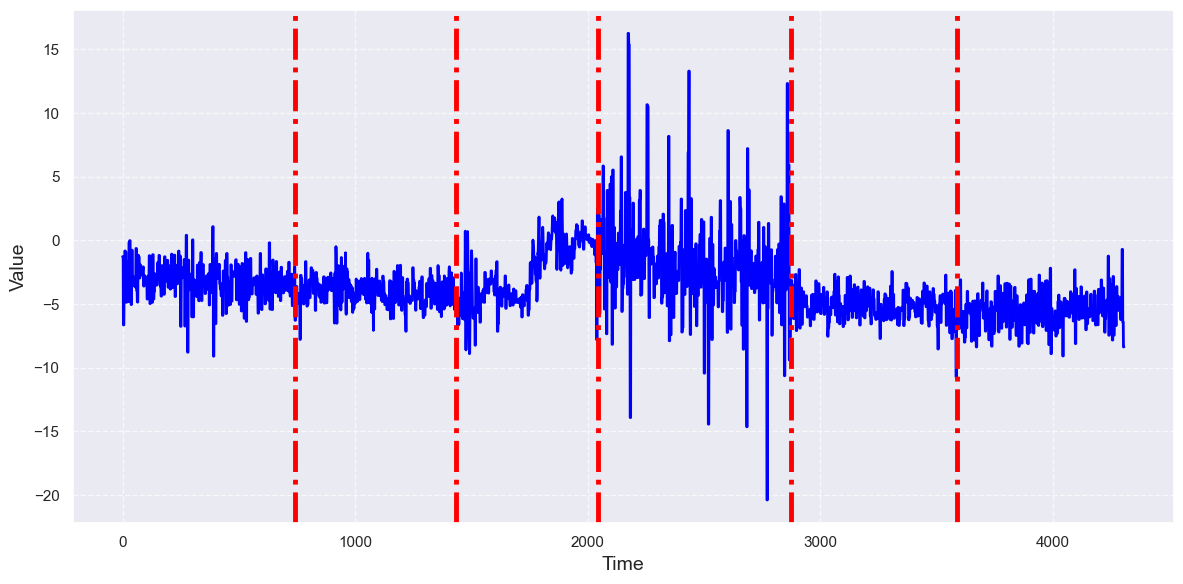

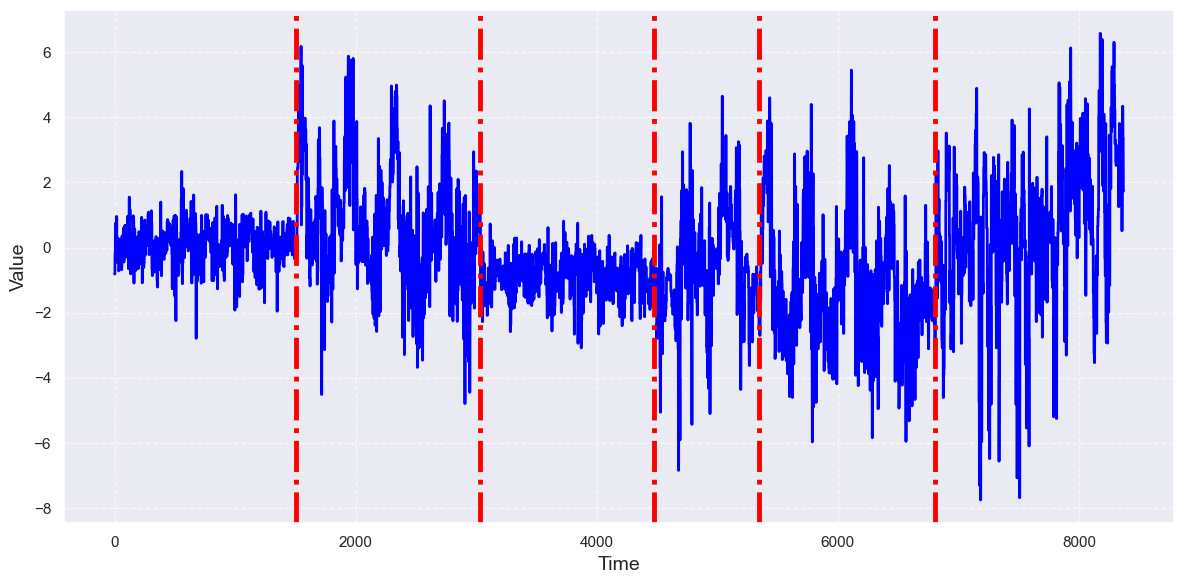

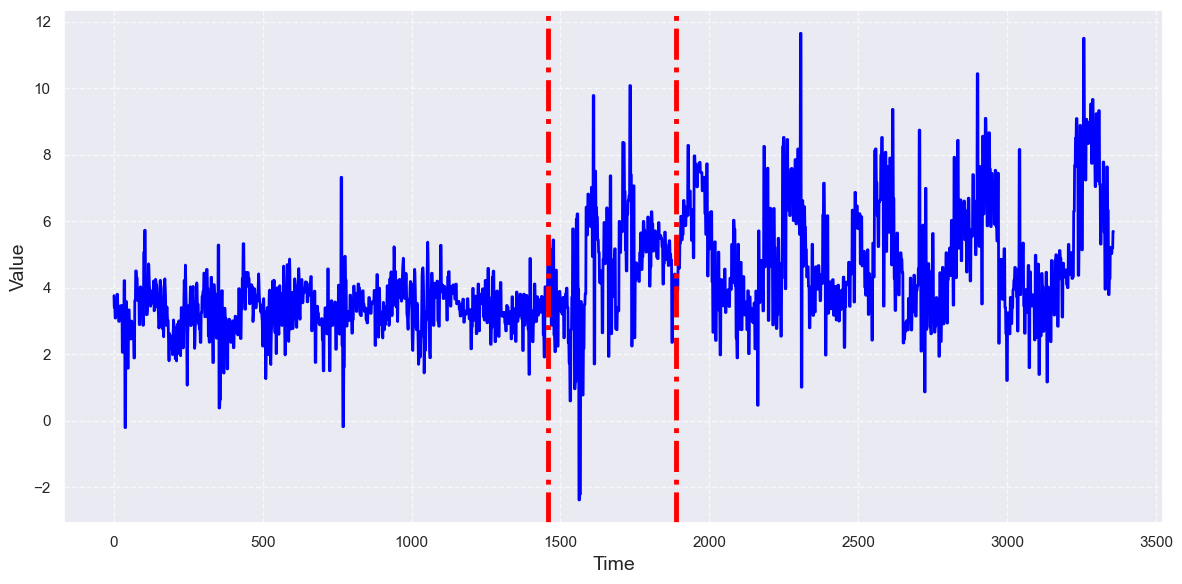

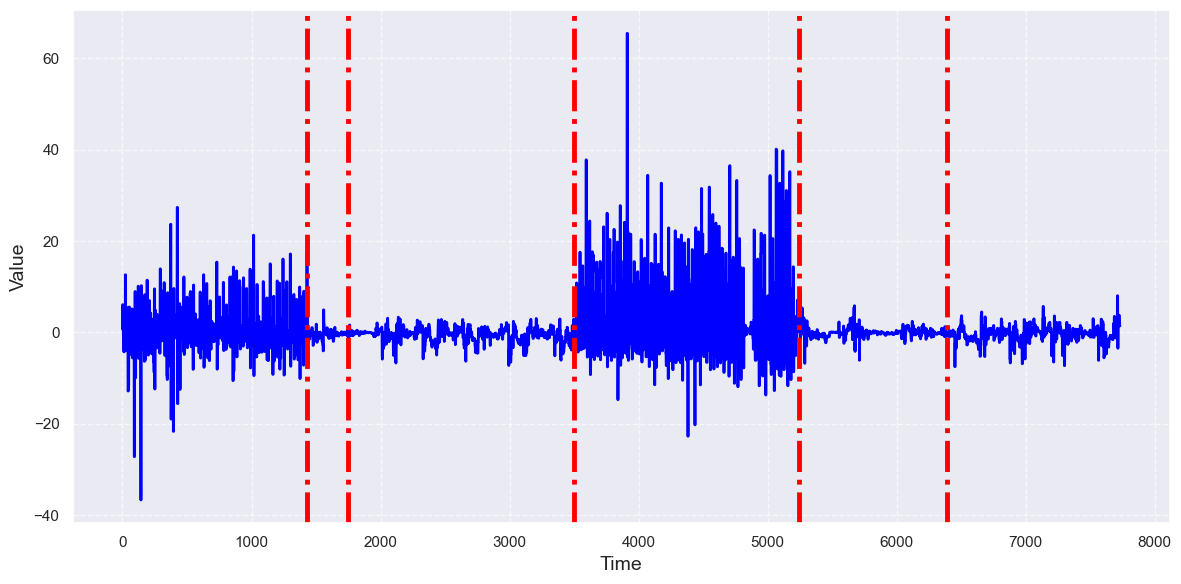

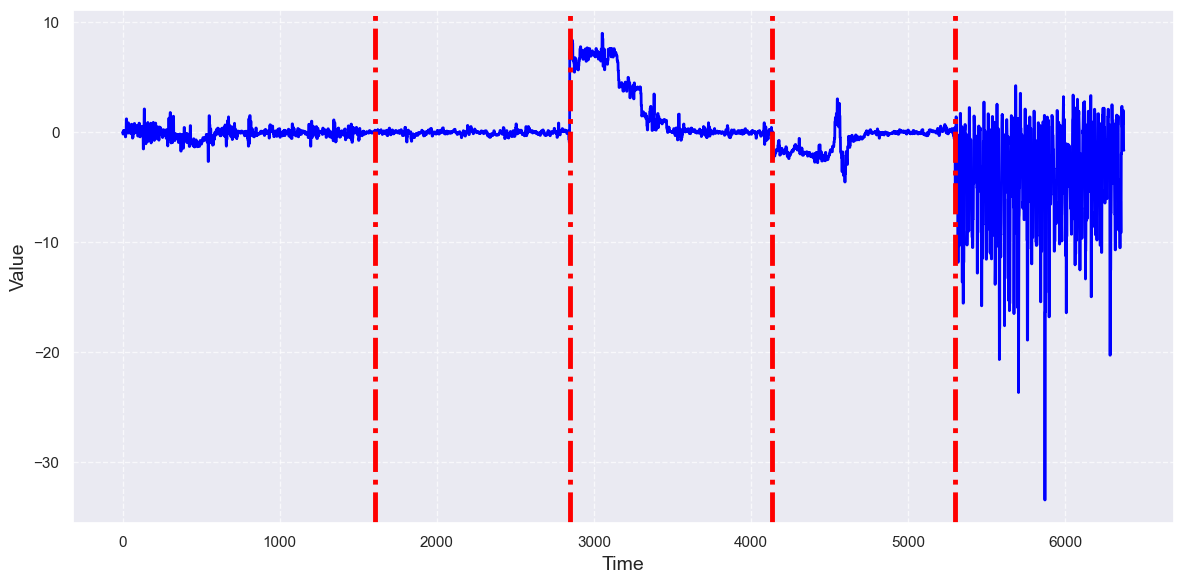

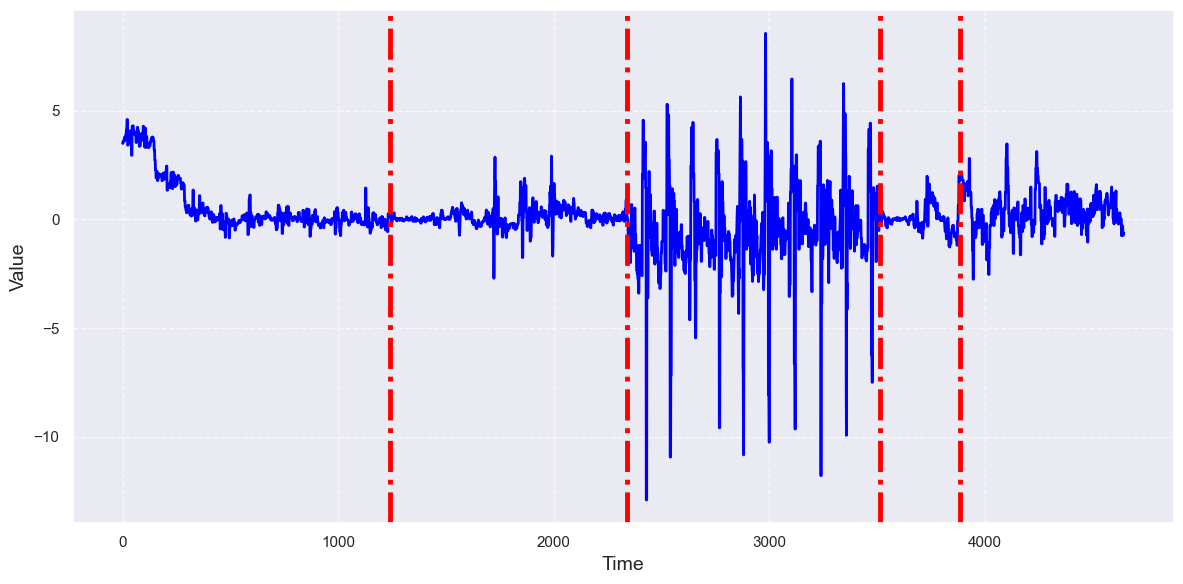

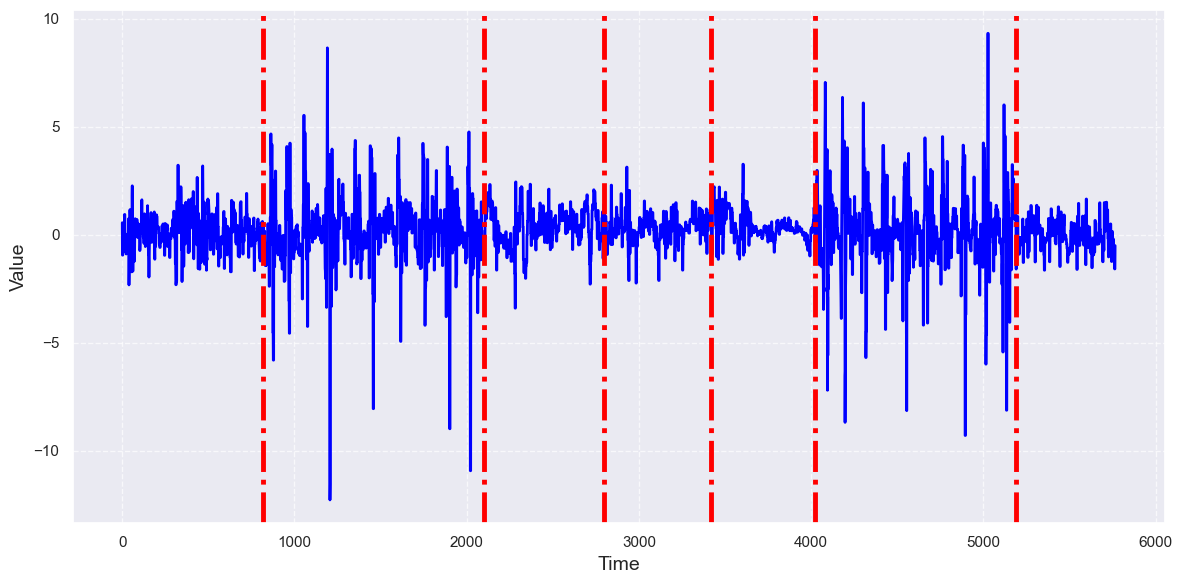

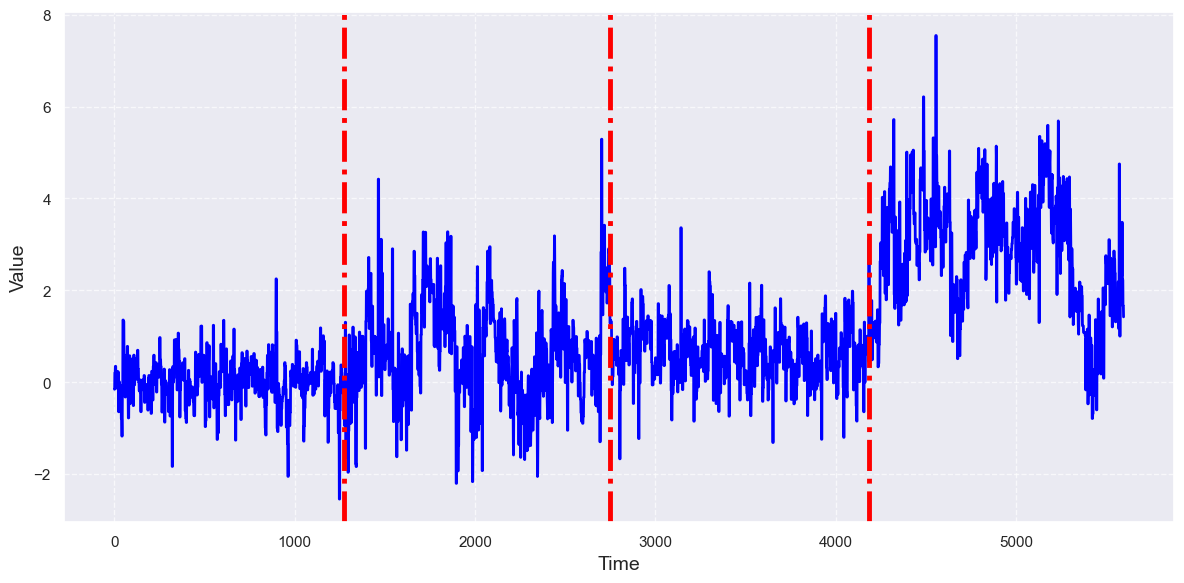

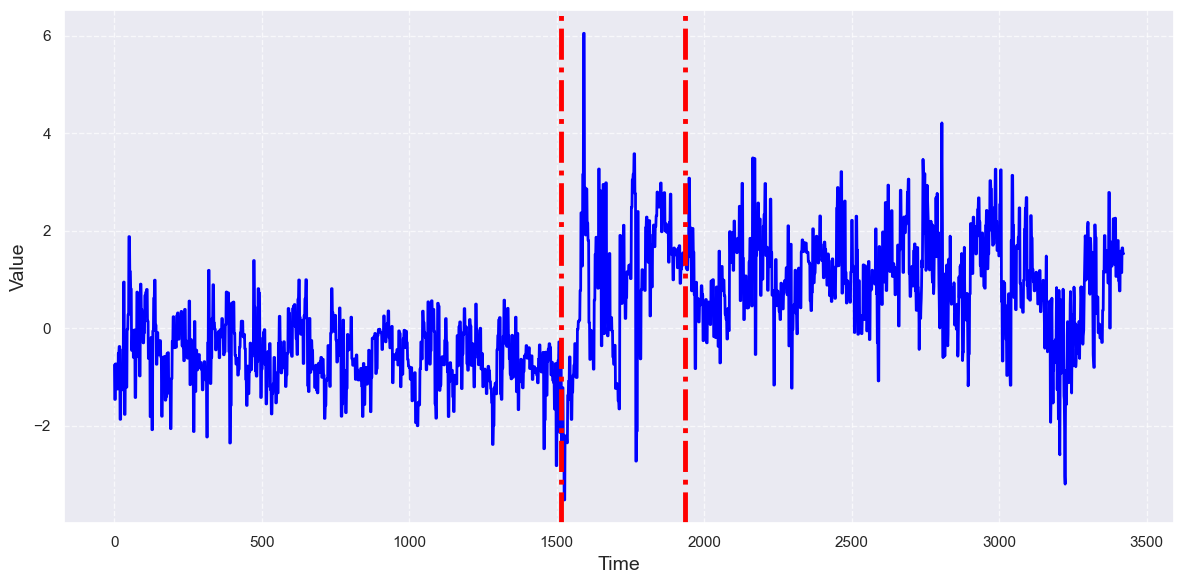

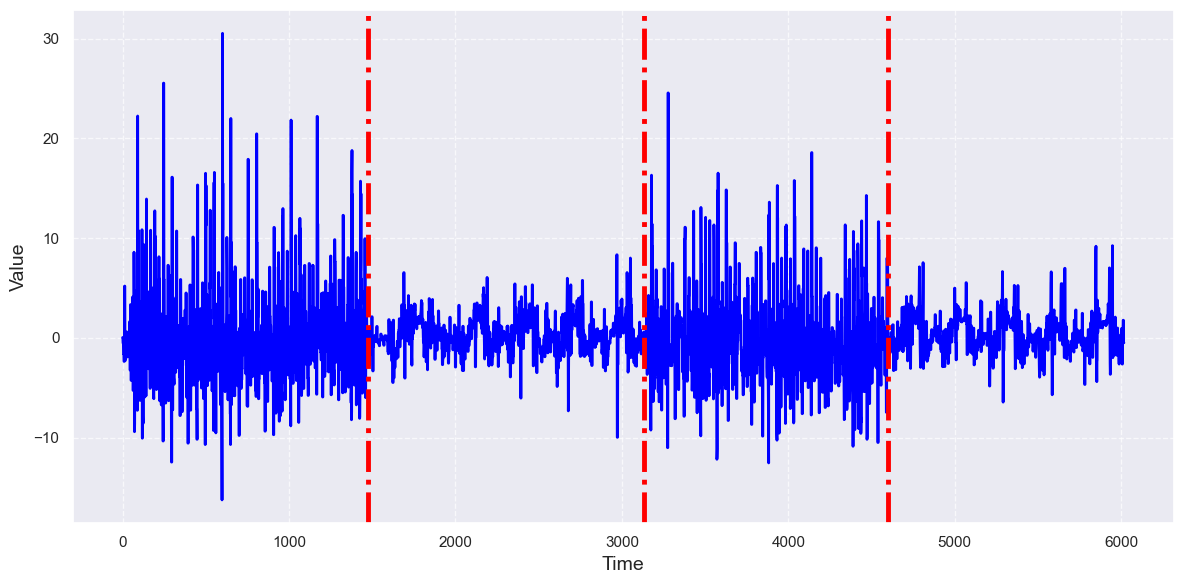

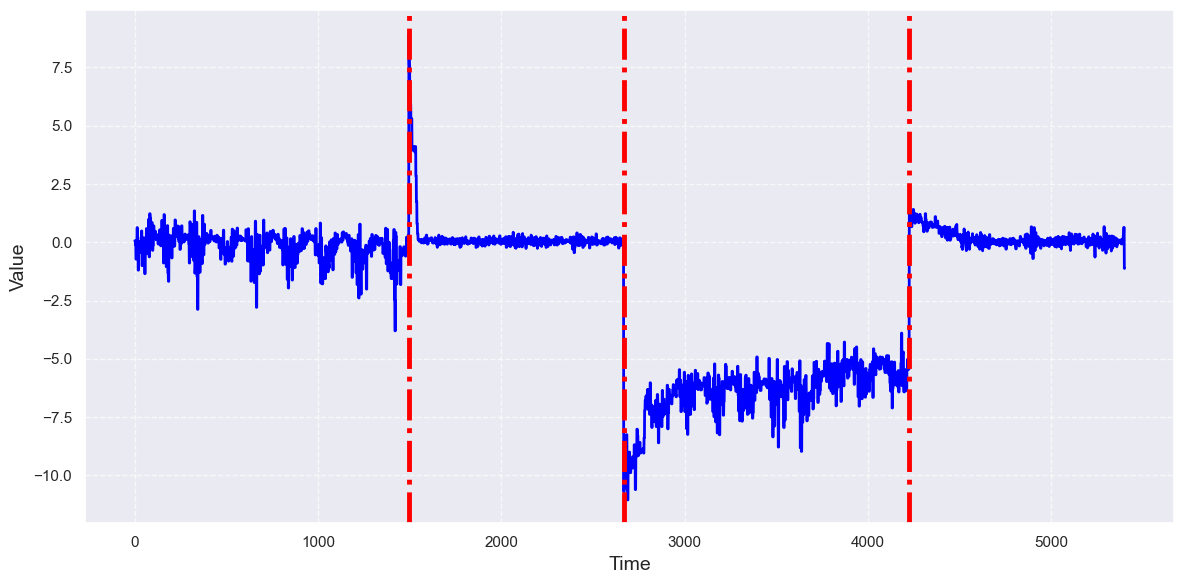

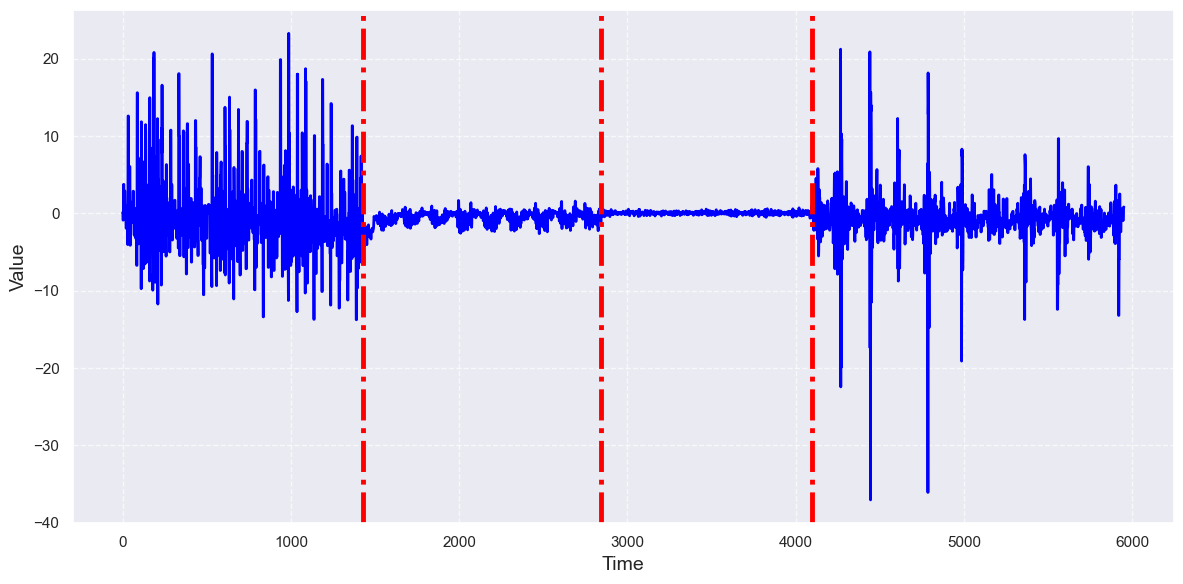

In [81]:

for i in range(15):
    change_points = CLaSP_segmenter(has_for_tcnautoencoder.loc[i, 'time_series'])

    plot_changepoints_on_ts(has_for_tcnautoencoder.loc[i, 'time_series'], change_points, has_for_tcnautoencoder.loc[i, 'dataset'], has_for_tcnautoencoder.loc[i, 'change_points'])